In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import findspark
findspark.init()

import pyspark
from pyspark.sql import *
import pyspark.sql.functions as func
from pyspark.sql.types import *

import sys
sys.path.append('../src')

import plot_correlation as pc
import plot_nlp as pn

%load_ext autoreload
%autoreload 2

%run insights.py
%run plot.py
%run communities.py

sns.set()

In [2]:
# Create spark session
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [11]:
# Load all datasets
metrics = spark.read.load('../data/dataset_metrics.parquet').toPandas()
score_metrics = spark.read.load('../data/score_metrics.parquet').toPandas().set_index('score')
comments = spark.read.load('../data/sample.parquet')
daily_metrics = spark.read.load('../data/daily_metrics.parquet').toPandas().set_index('created')
subreddit_agreement = spark.read.load('../data/subreddit_agreement.parquet').toPandas().set_index('subreddit')
daily_agreement = spark.read.load('../data/daily_agreement.parquet').toPandas().set_index('created')
lda_result_one_w_df = spark.read.load('../data/oneW_oneT_lda_result.parquet').toPandas().set_index('post_id')
lda_result_three_w_df = spark.read.load('../data/threeW_twoT_lda_result.parquet').toPandas().set_index('post_id')
nlp_metrics_full = spark.read.load('../data/daily_nlp_metrics_full.parquet/')
nlp = spark.read.load('../data/subreddit_nlp_full_0.001.parquet')
subreddits = spark.read.load('../data/subreddits.parquet')
nlp_per_community = spark.read.load('../data/nlp_per_community.parquet')
agreement_per_community = spark.read.load('../data/agreement_per_community.parquet').toPandas().set_index('Group')
agreement_per_subgroup = spark.read.load('../data/agreement_per_subgroup.parquet').toPandas().set_index('Subgroup')
monthly_contribs = spark.read.load('../data/monthly_contribs.parquet').toPandas()

# Register SQL tables
comments = comments.withColumn('created', func.from_unixtime(comments['created_utc'], 'yyyy-MM-dd HH:mm:ss.SS').cast(DateType()))
comments.registerTempTable("comments")
subreddits.registerTempTable('subreddits')
nlp.registerTempTable("nlp")

# Milestone 2 - Descriptive Analysis and Data Collection

### Dataset Description

##### Source

Our dataset contains all the comments available on Reddit from December 2005 to March 2017. It was firstly parsed and publicly maide avaible by a reddit user by the name of u/Stuck_in_the_Matrix [on 2015](https://www.reddit.com/r/datasets/comments/3bxlg7/i_have_every_publicly_available_reddit_comment/). Two years later, the user u/Dewarim provided torrents for [an updated version of the dataset](https://www.reddit.com/r/datasets/comments/65o7py/updated_reddit_comment_dataset_as_torrents/) which also includes all the comments from 2015 up to March 2017. This updated version is the one used as our dataset.


##### Overview & Schema

Before diving into the information we extracted from the dataset, let's look at the types of values that are contained within it. 

In [4]:
comments.printSchema()

root
 |-- distinguished: string (nullable = true)
 |-- retrieved_on: string (nullable = true)
 |-- gilded: integer (nullable = true)
 |-- edited: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- flair_text: string (nullable = true)
 |-- author: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- ups: integer (nullable = true)
 |-- downs: integer (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_context: string (nullable = true)
 |-- flair_css_class: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- score_hidden: boolean (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- controversiality: integer (nullable = true)
 |-- body: string (nullable = true)
 |-- archived: boolea

In the context of our data collection, we specifically looked at the following types,

* `created_utc` to be able to date the comment
* `author`, `subreddit_id` and `link_id` to aggregate the comments per author, topic or post.
* `ups`, `downs` and `score` to represent the high-level sentiment of the community with regards to the comment.
* `controversiality`, which is a pre-computed metric of controversiality.
* `body` in order to extract topics and sentiment from the text itself.

We will dive successively into each of these topics in this notebook. But first, let's start with the basic information about the dataset, i.e. its size and range of dates.

In [5]:
insights_comments(metrics)

> The dataset contains a total of **3,092,028,928** comments ranging from **12/12/2005** to **03/31/2017**.

An important thing to note given the schema seen above is that we do not have access to the content of the posts, only the comments. We do however have access to the id of the post (`link_id`) on which the comments are written. We can use this information, for instance to group comments that related to the same post. It is also possible to calculate the total number of posts (with at least one reply) on Reddit.

In [6]:
insights_posts(metrics)

> There is a total of **204,469,276** posts on Reddit with at least one reply.

Moreover, it is also important to understand the notion of *thread* in Reddit comments. Each comment has a parent, defined by `parent_id`. It means that comments might be at different depth. Top-level comments (which have depth 0 and answer the original post directly) will have the post id as `parent_id`. Lower-level comments on the other hand, have another comment as parent. We can use this information to extract the number of top-level comments and lower-level comments from the dataset.

In [7]:
insights_comments_levels(metrics)

> Out of all the comments, **1,223,260,504** (**39.56%** of the dataset) are top-level comments. This makes an average of **5.98** top-level comments per post. The other **1,868,768,424** (**60.44%**) are replies to other comments.

##### Deleted and Removed Comments

Some comments are marked as `[deleted]` or `[removed]`. According to [this Reddit post](https://www.reddit.com/r/help/comments/38cjx8/user_delete_vs_mod_delete_how_to_tell_the/), the `[deleted]` means that the comment was simply deleted by its author. There are a few reasons to do that, for instance to hide a negative comment from one's history, or to avoid getting more downvotes that we already have and prevent one's karma from getting too low. 

In [8]:
insights_removed(metrics)

> A total of **186,592,666** comments were deleted by their authors, which is **6.03%** of the dataset.

On the other hand, `[removed]` indicates comments that were removed from the moderation team of the subreddit that the comment belongs to. This can also indicate potential toxic or vulgar comments, but it is not very reliable as it can also include off-topic comments.

In [9]:
insights_deleted(metrics)

> A total of **25,544,034** comments were removed by the moderation teams, which is **0.83%** of the dataset.

##### Score

On Reddit, people can *upvote* (`ups` in the dataset) posts or comments that they agree with, and *downvote* (`downs`) comments with which they do not agree. These values are then used to calculate a `score` metric with a simple formula `ups - downs`. 

Unfortunately for us, even though the dataset sometimes include `ups` and `downs` attributes, their value seems to be completely wrong. In fact, there is no instance where `downs` is different than 0.

In [10]:
spark.sql("""SELECT downs, COUNT(*) FROM comments GROUP BY downs""").show()

+-----+--------+
|downs|count(1)|
+-----+--------+
| null| 2637603|
|    0| 3543945|
+-----+--------+



This is very problematic for us, as we were hoping to come up with our own formula for measuring polarity based on the number of upvotes and downvotes of a comment. For now, we will have to restrict ourselves to only using `score`. Let's see what the range of `score` is.

In [11]:
insights_score(score_metrics)

> The highest score of all the dataset is **88,484** and the lowest score is **-12,063**.

Now, let's look at the distribution of `score`. Since it can be negative, we will have to plot the positive and negative scores separately. (and it is required for log-log plots).

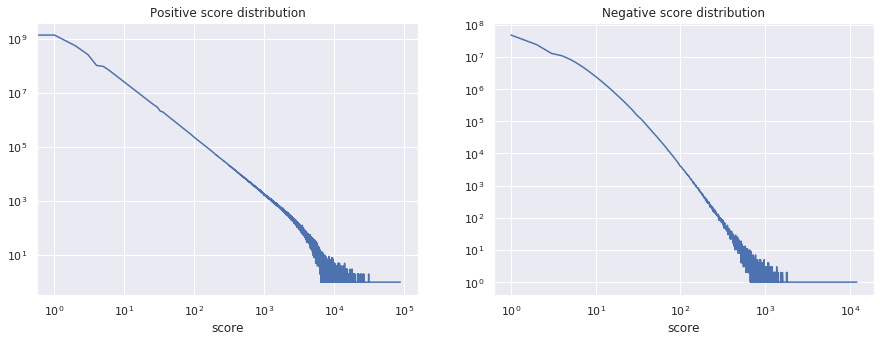

In [12]:
plot_scores(score_metrics)

We can see that the positive score seems to follow a nice power law. Interestingly enough, the negative score is not as straight and indicates that the negative scores do not follow the same power law as the positive scores do. 

### Evolution over Time

Now, our goal was to understand how the Reddit community has evolved in terms of controversiality, polarity and aggressivity over time. Our first step towards understanding such evolution was to visualize how the above metrics (as well as additional ones) have changed over the years.

##### General Reddit Traffic

Let's first see how the overall traffic has evolved over Reddit. Because the daily data can be very noisy (in blue below), we perform a 60-day window average for all of the following metrics (in orange). 

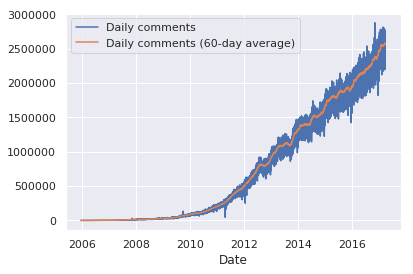

In [13]:
plot_daily_metric(daily_metrics, "count_of_comments")

We can see here that the number of comments on Reddit, after a slow start between 2005 and 2009, has ever since been steadily increasing. Moreover, the curve is similar to the **daily active users** which we can see below.

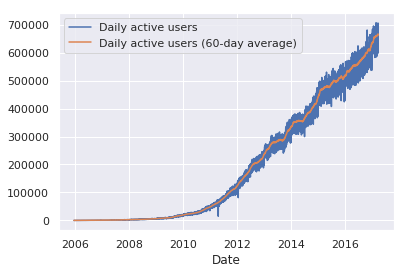

In [14]:
plot_daily_metric(daily_metrics, "count_of_users")

### Polarity & Controversiality Metrics

Now, we would like to narrow our focus down to the idea of measuring divisiveness on Reddit. Even before diving into the text of the comments, there are some high-level metrics that we can try to compute based on some of the attributes, for instance the `score`. Here is a list of such metrics and how they changed in time.

##### Controversiality

As we can see in the dataset schema, Reddit does provide a binary flag `controversiality` for each of the comments. If we trust [Koooooj
's explanation](https://www.reddit.com/r/NoStupidQuestions/comments/3xmlh8/what_does_something_being_labeled_controversial/cy5yk1m), as well as Reddit's [announcement of the feature](https://www.reddit.com/r/announcements/comments/293oqs/new_reddit_features_controversial_indicator_for/) a comment is flagged controversial when both down and up votes are high but their difference gets under a certain undisclosed threshold. In other words, Reddit will consider something to be controversial whenever it receives a high similar amount of down and up votes, which means that the community was evenly polarized by the comment's content.

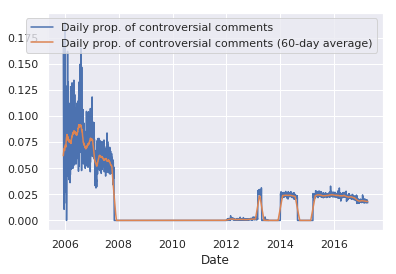

In [15]:
plot_daily_metric(daily_metrics, "prop_of_controversial")

Unfortunately, as we can see here, the `controversiality` metric is set to `0` to all the posts between 2008 and 2012, and there are two more gaps after that. Based on this, it will not be a very valuable metric over the long term. We might still be able to use it from 2015 onward, as it seems to be working properly there.

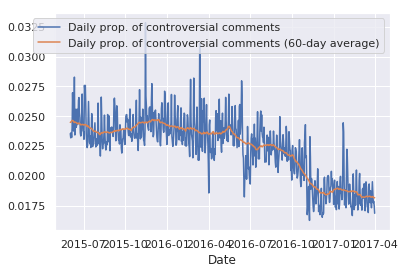

In [16]:
plot_daily_metric(daily_metrics[daily_metrics.index > dt.date(2015, 6, 1)], "prop_of_controversial")

##### Deletion and Moderation

Another indirect metric that could be interesting to look at is the number of comments that were removed from the moderation. Such comments are identifiable by the fact that their body has changed to `[removed]`. This also means that we do not have access to the previous content of such messages. We do not believe that this metric is meaningful enough on its own, but it could be interesting to use it as a supplement to another analysis. Again, there are many factors that could contribute to a post being removed, for instance if it breaks the rules of a subreddit.

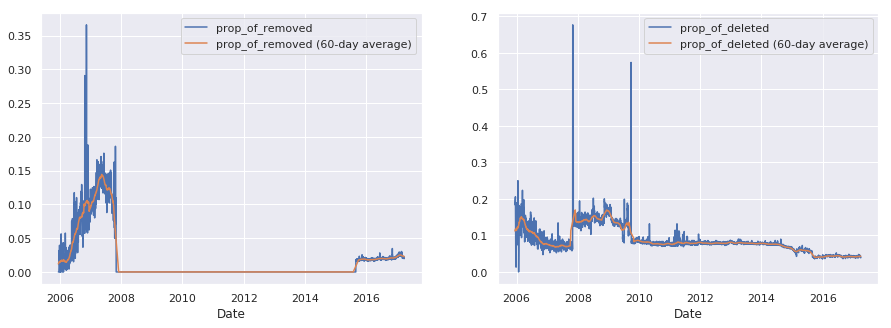

In [17]:
plot_daily_metrics(daily_metrics, "prop_of_removed", "prop_of_deleted")

These plots seem to indicate that there is some inconsistencies in how to dataset handles `[removed]` and `[deleted]`, which contradicts our original assumption. Moreover, the date after which `[removed]` is consistently 0 seem to coincide with the big spike seen in the number of `[deleted]`. One possible explanation would be that after this date, all `[removed]` were actually changed to `[deleted]`.

##### Agreement Factor

Now for a first metric that we computed by hand, the agreement factor is actually something fairly easy to compute. It basically takes the ratio of comments with positive score over the total number of comments. The intuition is that in controversial topics and/or echo-chamber situations, more posts are expected to be downvoted by the dominant community. 

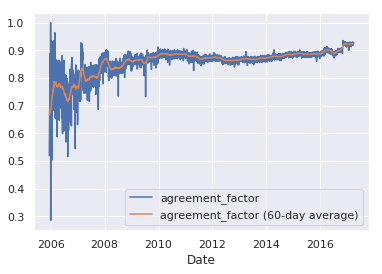

In [18]:
plot_daily_metric(daily_agreement, 'agreement_factor')

This result contradicts what we were expecting, as we can see that the *agreement factor* has actually been increasing relatively steadily. This could however hint at the fact that Reddit has become more of an echo chamber over time. Of course, this might not be the only factor, and there might be several biases related to this metric. For instance, a post with negative score does not necessarily indicate a divergence of opinion, it could simply be a post that does not respect the rules of a community, someone providing wrong information or a comment that does not add anything to the dicussion like "lol" or "ok".

We can also see on this graph that there is a spike around the beginning of 2017, let's zoom in to see exactly where.

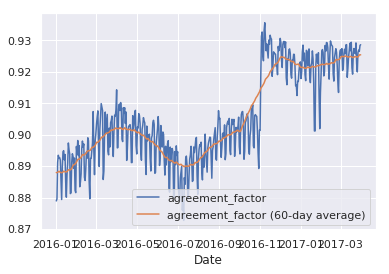

In [19]:
plot_daily_metric(daily_agreement[daily_agreement.index > dt.date(2016, 1, 1)], 'agreement_factor')

This spike in agreement seems to be located at the beginning of November. This exactly matches the moment at which the results of Trump's election came out. Is this a coincidence, or is there some underlying bias that we failed to take into account? We would have to do a more in-depth analysis to find out.

Finally, an interesting possible way to see if our "agreement factor" metric makes sense would be to visualize it per subreddit and see what the subreddits with lowest agreement factors are. Here are the first 20:

In [20]:
subreddit_agreement[subreddit_agreement['count'] > 3000][['count', 'agreement_factor']].sort_values('agreement_factor').head(20)

,count,agreement_factor
subreddit,,
blog,7350,0.724762
RocketLeagueExchange,18228,0.738644
GlobalOffensiveTrade,5607,0.764045
entertainment,4467,0.783747
xboxone,62751,0.798967
worldnews,577781,0.801754
worldpolitics,8246,0.802328
blackdesertonline,12471,0.804747
Austin,28946,0.808298


Interestingly, the lowest subreddit is **[r/blog](https://www.reddit.com/r/blog)**. One way to interpret this result is that this subreddit is managed by the Reddit company itself and is one of the few places where the community can express their opinion on the decisions and changes made by the Reddit developpers. In 2017, Reddit has announced and/or made some controversial updates to their app (e.g. redesigning the front page, modifying their ranking algorithm, etc..) and these polarizing topics could be represented by the result we get here.

Now for the remaining ones, it is interesting to see that they almost all fall into a few categories:

* **Video Games** - `r/RocketLeagueExchange`, `r/GlobalOffensiveTrade`, `r/xboxone`, `r/blackdesertonline`, `r/ConanExiles`, `r/kotk`, `r/bladeandsoul`, `r/PUBATTLEGROUNDS` are all subreddits dedicated to specific games or consoles. Given the fact that online games tend to always be somewhat toxic (taken from our own experience), this was indeed to be expected.
* **Politics & News** - As we could also expect, subreddits linked to politics and news have a low agreement factor. `r/worldnews`, `r/news` and `r/worldpolitics` all rank very low here. Later on, it will be interesting to analyze how these specific subreddits have evolved over time.
* **Cities** - Interestingly enough, it seems that conversation might get controversial when talking about cities. This can actually makes sense, as these types of discussions are often fairly emotional and involve people with wildly different experiences and opinions. According to this metric, `r/Austin`, `r/Minneapolis` and `r/nyc` are the top 3 cities about which are less in agreement.

We also note the present of `r/subredditcancer`, which seems to be the home of users who got banned from other subreddits because of their sometimes extreme opinions, as well as `r/TwoXChromosomes`, a subreddit dedicated to conversations about and between women and `r/RealGirls` \[**NSFW**\] an amateur pornographic subreddit about women.

### Trend Modelling

In order to detect trends in such a big dataset we need some way to extract the discussion's subject from reddit threads. One common and efficient way to perform this on textual data, is to use the Latent Dirichlet Allocation (LDA) algorithm which given a text input and some hyper parameters, can extract a variable number of topics from the text. 

#### Trend analysis of the month preceding the election, using 1 topic by post, and 1 word per topic

To test the efficiency of LDA on reddit discussions, we ran the algorithm on all comments from the subreddit "news" during the month preceding the 2016 US presidential election, to see if indeed the upcoming election was discussed. This could prove to be useful in the light of the preceding findings, as _r/news_ is part of the subreddit with the lowest agreement factor. Thus it could be useful to understand on which subject the reddit users are not agreeing and polarized.

The most simple and general topic modelling that can be done, is asking the LDA to produce only one topic consisting of 1 word per post. Let's see what was the 20 most discussed topic during this month, according to the frequency of each topic per post:

In [21]:
frequency_df = lda_result_one_w_df['topic'].value_counts()
frequency_df.head(20)

people      394
would       135
police       77
article      50
school       41
child        39
trump        38
woman        35
pipeline     33
clown        33
could        29
state        28
attack       26
actually     25
black        25
phone        24
right        24
american     23
russia       22
officer      22
Name: topic, dtype: int64

With only one topic limited to one word, we obviously generalize a bit too much the discussions and we get very broad subjects such as "people" as the most frequent topic. Of course, most of the discussions about news might be centered around people, so it does not really come as a surprise. Most of the other frequents topics are terms which easily get some miscellaneous headlines in news outlet such as "police", "school", "state", "phone" or "crime". 

However the word "trump" still appear to be the fifth most frequent topic during this timeframe, which comes as no surprise, as this data sample is centered on the month before the election day. Nonetheless, the relative frequency of this topic is a good news for our research. It shows that "trump" was indeed an important topic of discussion in reddit news the month before the election meaning the LDA may help us identify some trends in discussions.

The rival of Donald Trump for the 2016 election, Hillary Clinton, is surprinsingly absent from this ranking. This could either means she was less discussed than Donald Trump, or that more often the LDA would categorize another word as being the topic of the thread (such as "woman" potentially). 

Let's plot comparatively the number of post whose subject was one of the two presidential candidates during this month :

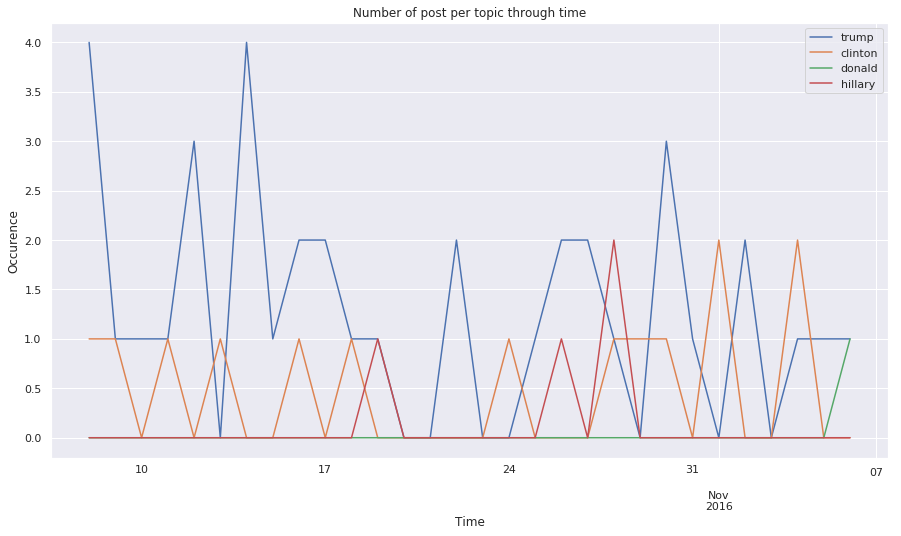

In [22]:
topics = ['trump', 'clinton', 'donald', 'hillary']
plot_frequency_of_topics(lda_result_one_w_df, topics)

The plot above shows us an interesting phenomena, although the word "clinton" and "hillary" were absent from the 20 most discussed topic we showed previously, both words seems to share a similar distribution in magnitude through time, whereas for Donald Trump, most of the time he's subjectified by its family name rather by its first name (which get recognized as a topic only once, on the 6th of November). Even though "clinton" might be referring to another person bearing this family name, the context of the election assures us this word probably refers to the same person as the word "hillary".

This might explain why Hillary Clinton was not as subjectified as Donald Trump according to the LDA results, the people would refer to her under two different words during discussion, while they would be more consistent with the current U.S. president by calling him "Trump".

Merging all the possible word as name for the presidential candidate gives us this distribution through time instead:

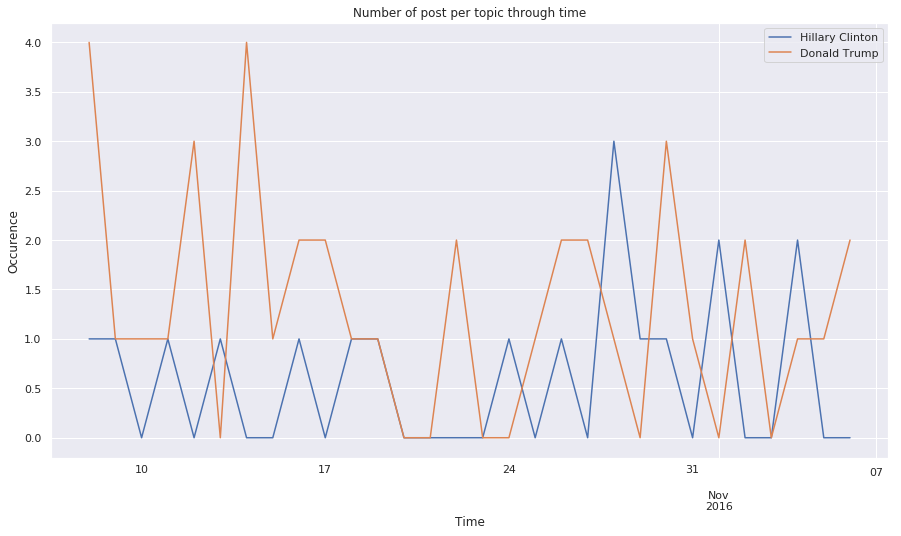

In [23]:
hc = 'Hillary Clinton'
dt = 'Donald Trump'
lda_result_one_w_df['topic'] = lda_result_one_w_df['topic'].map({'hillary': hc, 'clinton': hc, 'donald':dt, 'trump':dt})
plot_frequency_of_topics(lda_result_one_w_df, [hc, dt])

The corrected occurence through time distribution shows us that although Trump was the dominant subject at the beginning of the month of October, both subjects started to have an equal representation as the election day was coming.

This proves some trend analysis can be done using LDA, but we should take it with a grain of salt, as the number of occurence stays relatively low (under 5 posts whose topic was identified to be about a presidential candidate per day), probably because LDA will favor more general terms such as "people" or "would" as topic of discussion.

#### Trend Analysis using 2 topics by post, and 3 words per topic

The LDA algorithm allows some more fine grained topic modelling by changing the number of topic produced by thread, and the number of words that can constitute a topic. Testing LDA on the same sample but with increased topic and words per topic might maybe produce less general topics and maybe more representativeness of the actual topic of discussion. 

In [24]:
lda_result_three_w_df['topic'].value_counts().head(30)

people would think         10
people black white          8
right                       6
police people would         4
people would money          4
video                       4
alive                       4
people think would          4
pretty                      4
people black police         4
insurance people health     3
people driving think        3
people right would          3
insurance people would      3
would people police         3
pipeline would people       3
police would officer        3
would people think          3
people white black          3
people would government     3
recover                     2
people white would          2
child could people          2
house                       2
suuurre                     2
child penalty death         2
church catholic priest      2
trump would people          2
really                      2
rifle assault automatic     2
Name: topic, dtype: int64

Obviously, computing three words per topic greatly decreases the odds of having a high count for a given topic, as the most frequent topic being "people would think" occurs only 10 times through all the posts (whereas the topic "people" occured 394 times when considering only one word per topic). Having three words per topic gives a bit more information about the thread's subject, but give less chance of finding a coherent trend.

Regarding the U.S. election, no identical topics seems to adress the subject, but this might be because most topics modelled by the LDA about either Trump or Clinton are not coherent enough to be counted together. We can assume that a three words topic containing the name of either presidential candidate might speak about it, and thus count this way how much Clinton and Trump were discussed.

In [25]:
def replace_str(s):
    if s == 'hillary' or s == 'clinton':
        return hc
    elif s == 'donald' or s == 'trump':
        return dt
    else:
        return s

count_dict = {hc:0, dt:0}
for t in lda_result_three_w_df['topic']:
    ts = t.split(' ')
    ts = [replace_str(tok) for tok in ts]
    for k in count_dict.keys():
        if k in ts:
            count_dict[k] += 1
count_dict

{'Hillary Clinton': 92, 'Donald Trump': 173}

We get a much higher count of occurence in topics for the two presidential candidate than in previous exemple. This means that finding the good number of topics per post and words per topic, might help in correctly modelling the topic of a post, and thus detect trends.

### Extracting Tone and Vulgarity using NLP [WIP]

In addition to Topic Modelling, we tried to use natural language processing as a means to analyze the tone (positive, neutral, negative) and lack of repspect (vulgarity, hate speech) of each of the comments. Unfortunately, due to the size of the dataset, we were so far only able to run it on a few days (the first 5 days of January 2017). 

In [26]:
nlp_per_day = nlp_metrics_full.withColumn('dummy', func.lit(1)).groupBy('creation_date').sum()
pd_per_day = nlp_per_day.toPandas().set_index('creation_date').sort_index()
pd_percentage = pd_per_day.iloc[:, :-1].div(pd_per_day.iloc[:, -1], axis=0)
pd_percentage

,sum(nltk_negativity),sum(nltk_neutrality),sum(nltk_positivity),sum(text_blob_polarity),sum(text_blob_subjectivity),sum(nb_bw_matches),sum(nb_hw_matches),sum(hw_ref_intensity),sum(nb_hw_ref_matches)
creation_date,,,,,,,,,
2017-01-01,0.080891,0.769968,0.147190,0.008921,0.036027,0.094443,0.015949,0.001288,0.002093
2017-01-02,0.078461,0.777082,0.142812,0.009211,0.036637,0.094494,0.017424,0.001502,0.002413
2017-01-03,0.077053,0.780049,0.141465,0.009071,0.036886,0.092205,0.017310,0.001556,0.002474
2017-01-04,0.076854,0.781258,0.140451,0.009240,0.037242,0.092980,0.017489,0.001422,0.002292
2017-01-05,0.079842,0.779283,0.139467,0.009249,0.036869,0.097295,0.018126,0.002556,0.004225


In [27]:
# Average of each attribute over the 5 first day of January 2017
pd_percentage_avg = pd_percentage.mean(axis=0)
pd_percentage_avg

sum(nltk_negativity)           0.078620
sum(nltk_neutrality)           0.777528
sum(nltk_positivity)           0.142277
sum(text_blob_polarity)        0.009138
sum(text_blob_subjectivity)    0.036732
sum(nb_bw_matches)             0.094283
sum(nb_hw_matches)             0.017260
sum(hw_ref_intensity)          0.001665
sum(nb_hw_ref_matches)         0.002699
dtype: float64

Here is the meaning of each attribute:
1. nltk_negativity: Negativity percentage of a comment computed with the NLTK library.
2. nltk_neutrality: Neutrality percentage of a comment computed with the NLTK library
3. nltk_positivity: Positivity percentage of a comment computed with the NLTK library
4. text_blob_polarity: Polarity of a comment computer with the TextBlob library. Range: $x \in [-1, 1]$. -1 is negative polarity, 1 is positive polarity.
5. text_blob_subjectivity: Subjectivity of a comment computed with the TextBlob library. Range: $x \in [0, 1]$. 0 is very objective, 1 is very subjective.
6. nb_bw_matches: Percentage of messages containing bad words
7. nb_hw_matches: Percentage of messages containing hate words (The dataset used to compute this metric is very general)
9. hw_ref_intensity: Intensity of the hate words for the refined hate speech dataset (see below). Range: $x \in [0, 1]$. 0 is low intensity, 1 is very high intensity.
8. nb_hw_ref_matches: Percentage of messages containing refined hate words (The dataset used to compute this metric is less general, cleaner compared to the one use in nb_hw_matches)

##### Tone

We can already see in the result below that positive words seems to appear twice as much as negative words and that the vast majority of words that are used are neutral. Also, based on the subjectivity metrics, it seems that messages tend to be very objective, which is something we do not really expect for a social media. However, we must not forget that we are looking at a very small subsample of the dataset and therefore those metrics are not necessarily very relevant at the moment.

Notice that values don't seem to vary much from one day to another.

In [28]:
tone_metrics = pd_percentage.loc[:, :'sum(text_blob_subjectivity)']
tone_metrics

,sum(nltk_negativity),sum(nltk_neutrality),sum(nltk_positivity),sum(text_blob_polarity),sum(text_blob_subjectivity)
creation_date,,,,,
2017-01-01,0.080891,0.769968,0.147190,0.008921,0.036027
2017-01-02,0.078461,0.777082,0.142812,0.009211,0.036637
2017-01-03,0.077053,0.780049,0.141465,0.009071,0.036886
2017-01-04,0.076854,0.781258,0.140451,0.009240,0.037242
2017-01-05,0.079842,0.779283,0.139467,0.009249,0.036869


In [29]:
# Average of the metrics over the first 5 days of January 2017
avg_tone_metrics = pd_percentage_avg.loc[:'sum(text_blob_subjectivity)']
avg_tone_metrics

sum(nltk_negativity)           0.078620
sum(nltk_neutrality)           0.777528
sum(nltk_positivity)           0.142277
sum(text_blob_polarity)        0.009138
sum(text_blob_subjectivity)    0.036732
dtype: float64

##### Vulgarity

From the result below, we can see that in average, for the studied time period, 10% of messages contains bad words, and the quantity of messages containing hate speech varies from 0.2% based on the refined hate speech dataset to 1.7% based on the more general hatespeech dataset.

Notice that values don't seem to vary much from one day to another.

In [30]:
vulgarity_metrics = pd_percentage.loc[:, 'sum(nb_bw_matches)':]
vulgarity_metrics

,sum(nb_bw_matches),sum(nb_hw_matches),sum(hw_ref_intensity),sum(nb_hw_ref_matches)
creation_date,,,,
2017-01-01,0.094443,0.015949,0.001288,0.002093
2017-01-02,0.094494,0.017424,0.001502,0.002413
2017-01-03,0.092205,0.017310,0.001556,0.002474
2017-01-04,0.092980,0.017489,0.001422,0.002292
2017-01-05,0.097295,0.018126,0.002556,0.004225


In [31]:
avg_vulgarity_metrics = pd_percentage_avg.loc['sum(nb_bw_matches)':]
avg_vulgarity_metrics

sum(nb_bw_matches)        0.094283
sum(nb_hw_matches)        0.017260
sum(hw_ref_intensity)     0.001665
sum(nb_hw_ref_matches)    0.002699
dtype: float64

##### Tone and vulgarity conclusion

It is clear that the time period studied is too small to conclude anything about the full dataset. However, it already gives us an idea about value magnitudes expected. Work is still in progress for this part and we expect to have more detailed results in the near future.

# Milestone 3 - Deeper Analysis + Preparation of Report

### Long-Term Trend Analysis of NLP Metrics

In this part of the notebook, we simply display some NLP metrics we computed on messages and see if we can find interesting relationships between the metrics or interesting behaviors based on events that happened during the years studied.
The studied metrics are the following (all computed on each message): negativity, neutrality, positivity, polarity (mixed measure of negativity and positivity), subjectivity and bad words occurrences. We collected those metrics from two time periods: one time period was based on a subsample of the full dataset, which means the metrics were collected on messages created from 2005 to 2017. The other time period is based on a subsample of the years 2015-2017 to provide a zoom on more recent data. Sadly, the second period time does not give us any significant result and we decide therefore not to show them as the notebook would have been too big.

Note that due to the huge size of the dataset, we had to subsample the data randomly to be able to compute the metrics in a reasonable amount of time. We hope the subsample is representative of the full dataset but we cannot be absolutely sure it is really the case. Also, the early years of Reddit, Reddit did not contain much messages and you will therefore notice in the plots that the data is very noisy in those years of Reddit due to the random subsampling we had to do.

Please note as well that all metrics labelled as averages were computed with a 60-days window average.

##### Natural Language Processing - 2005 - 2017

In [32]:
nltk_plot_averages, nltk_plot_stat = pn.get_plot_nltk(full=True)
blob_plot_stat = pn.get_plot_blob(full=True)
bw_plot_stat = pn.get_plot_bw(full=True)
hw_plot_stat = pn.get_plot_hw(full=True)
ref_hw_plot_stat = pn.get_plot_ref_hw(full=True)

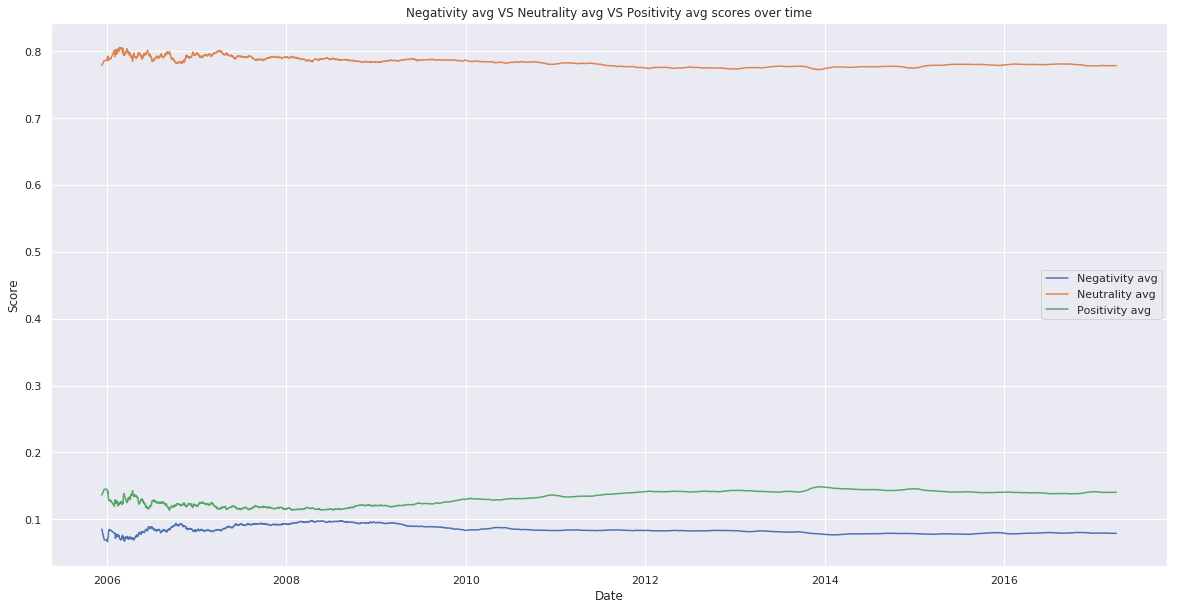

In [33]:
nltk_plot_averages()

This plot shows that neutrality is a the dominant component of all the messages of reddit. However, this metrics is not really interesting due to the way it is computed. The more "neutral" words a message have, the more neutral it will be. Neutral words include almost all words except the ones labelled as positive or negative. Therefore stop words are included in neutral words and the more stop words a message have, the more neutral the message become.
More generally, the positivity, negativity and neutrality metrics are computed as a sort of percentage based on the total number of words in messages. This is the reason why we observe very low scores for both negativity and positivity compared to the dominant neutrality in messages. Therefore, it is more interesting to compare the negativity against positivity as these should have more similar magnitudes. However, we can already observe that positivity is more present than negativity (~ twice as more positivity than negativity from 2012 to 2017). We know zoom on positivity and negativity metrics.

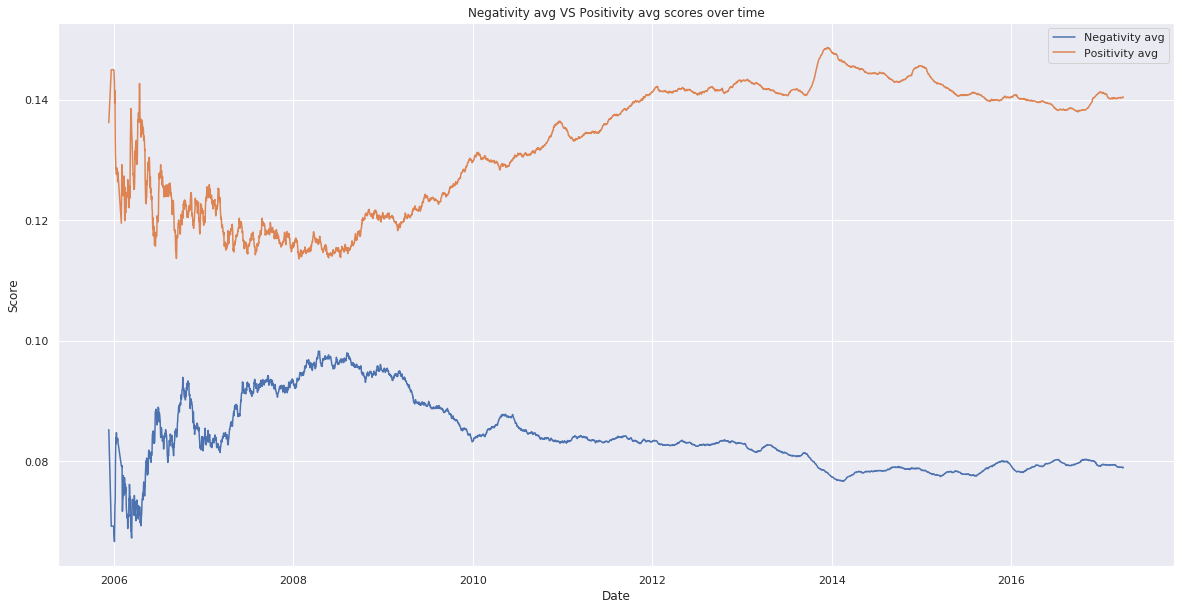

In [34]:
nltk_plot_averages(neu=False)

Now that we have a better view on both negativity and positivity metrics, we observe a symetrical pattern between the two. The apparent tendency over the years is that when positivity decreases, negativity increases and vice-versa. This result can look obvious, but is it actually not necessarily. Indeed, a decrease in positivity could have been replaced by an increase in neutrality.
Another interesting thing to notice is the shape of the curves themselves. The lowest positivity takes place around 2008, when the subprimes crash crisis took place. After that, the positivity starts growing again until 2014 and seem to decrease from there although it is not very clear. We observe a symetric behavior for negativity although negativity seems to remain quite stable from 2014 to 2017.

We now take a look at the polarity metric which is a mix between the negativity and positivity one.

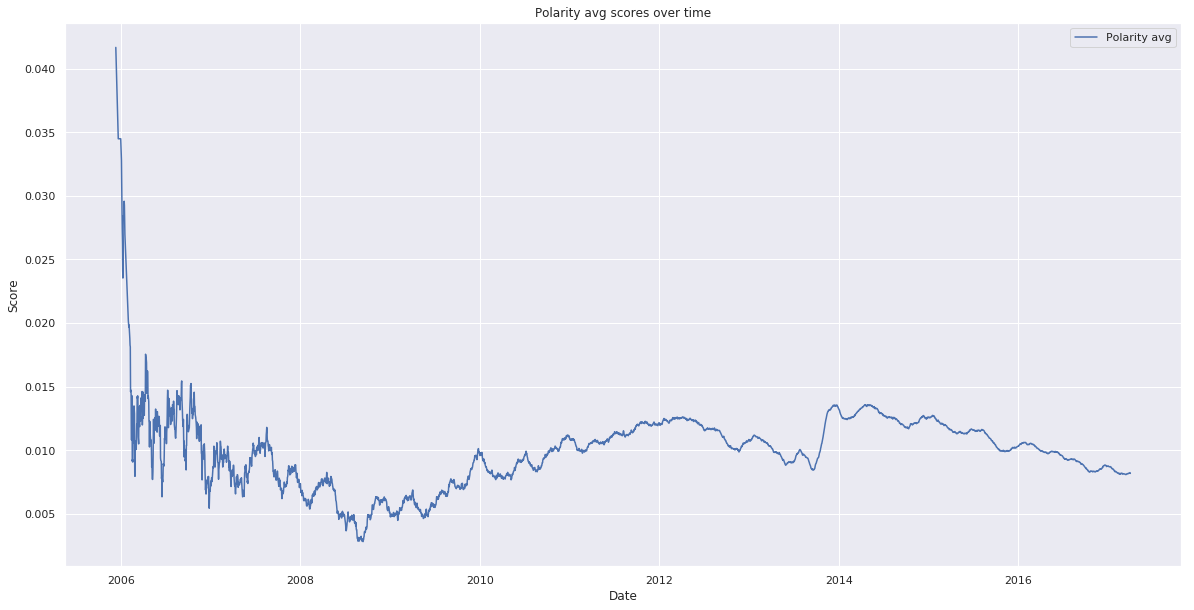

In [35]:
blob_plot_stat(pol_avg=True)

The first thing we observe is that the polarity curve never drops below zero, which confirms that Reddit messages are in general less positive than negative. The shape of the curve is also quite similar to the positive metric curve. The lowest peak is reached around 2008 and the curve starts to increases from there to reach its highest peak at the end of 2013 and finally decrease from 2014. Notice however that there is a gap present between 2012 and 2014 where the polarity metric decreases. This gap doesn't seem to be present in any of the curves we have seen until now.

We now zoom on the neutrality curve to see if we can find interesting behaviors.

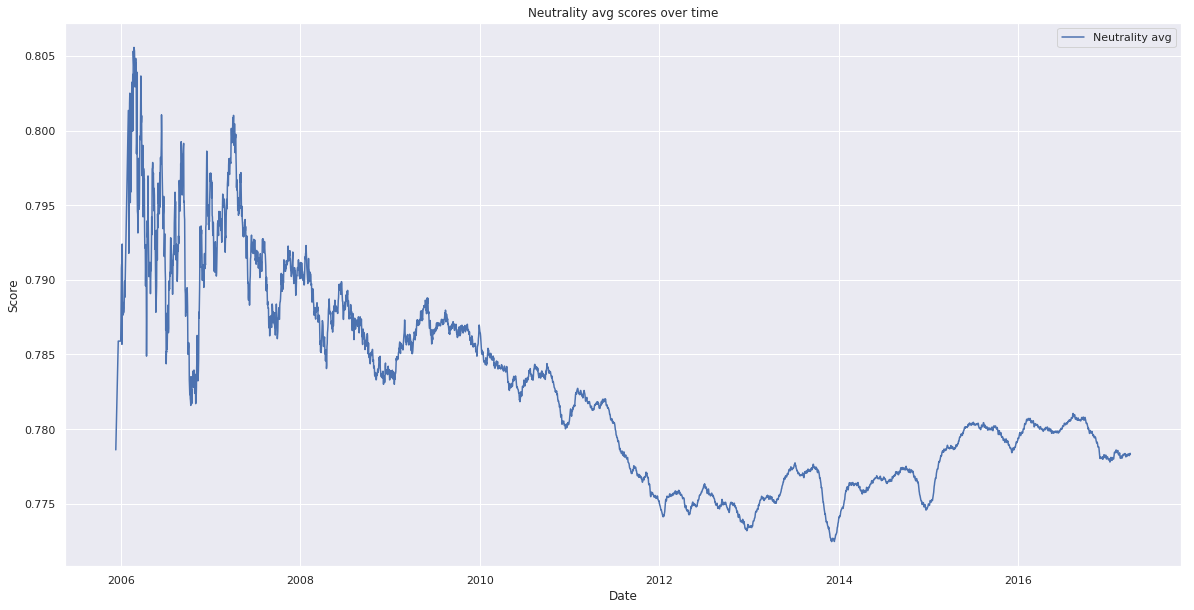

In [36]:
nltk_plot_averages(neg=False, pos=False)

Although the data seems to be very noisy, it is interesting to see that the overall neutrality of messages has decreased quite a lot from 2006 to 2012. Our hypothese is that in the early years of Reddit, people were not really used to social networks and therefore did not behave the same way they do nowadays. Social network were probably less opinion oriented and therefore more objective in their early days than today. We will try to verify this hypothesis by taking a look at the subjectivity metric below.
Notice as well that the peak in positivity we observed in 2014 can also be observed here. This positivity peak is translated as a decrease in neutrality. Also, neutrality seems to increase again since 2014 which is the opposite of what we observed for positivity before.

We now take a look at the subjectivity metric.

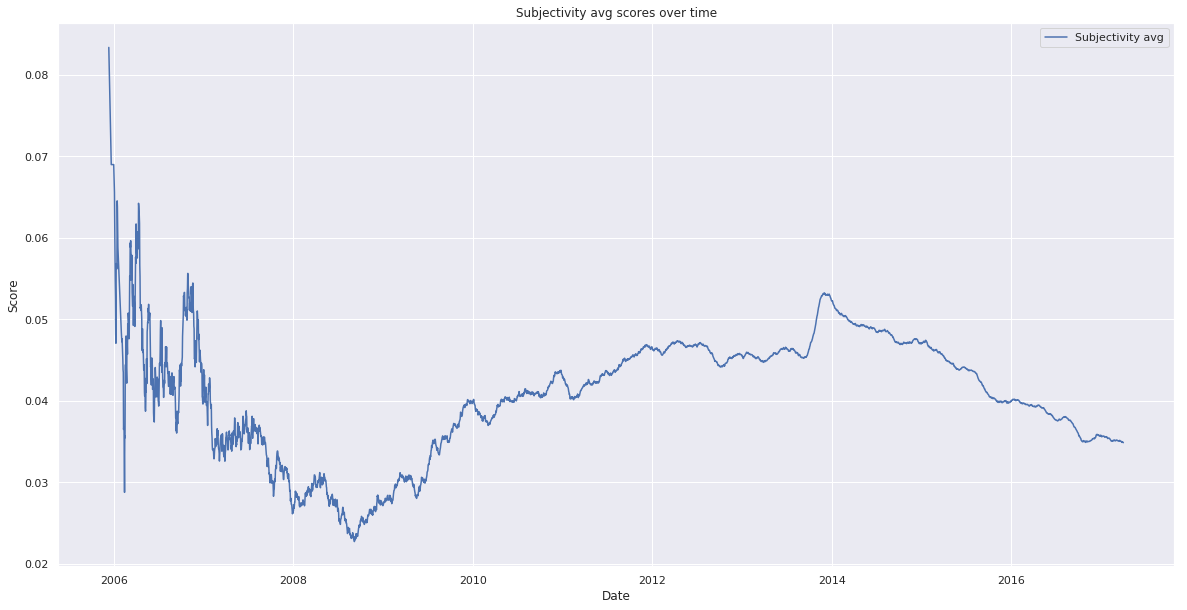

In [37]:
blob_plot_stat(subj_avg=True)

Funnily enough, the messages dating from the early years of Reddit were apparently at least as subjective as they are nowadays if not more. However, the subjectivity rapidly decreased to reach its lowest peak around 2008. Again, the subjectivity increased in the years following 2008 until 2014 where subjectivity starts to decrease again. It looks like the subjectivity metric is influenced quite a lot by the positivity metric as both curves looks quite similar in their tendencies over time.

We are now going to take a look at the bad words metric.

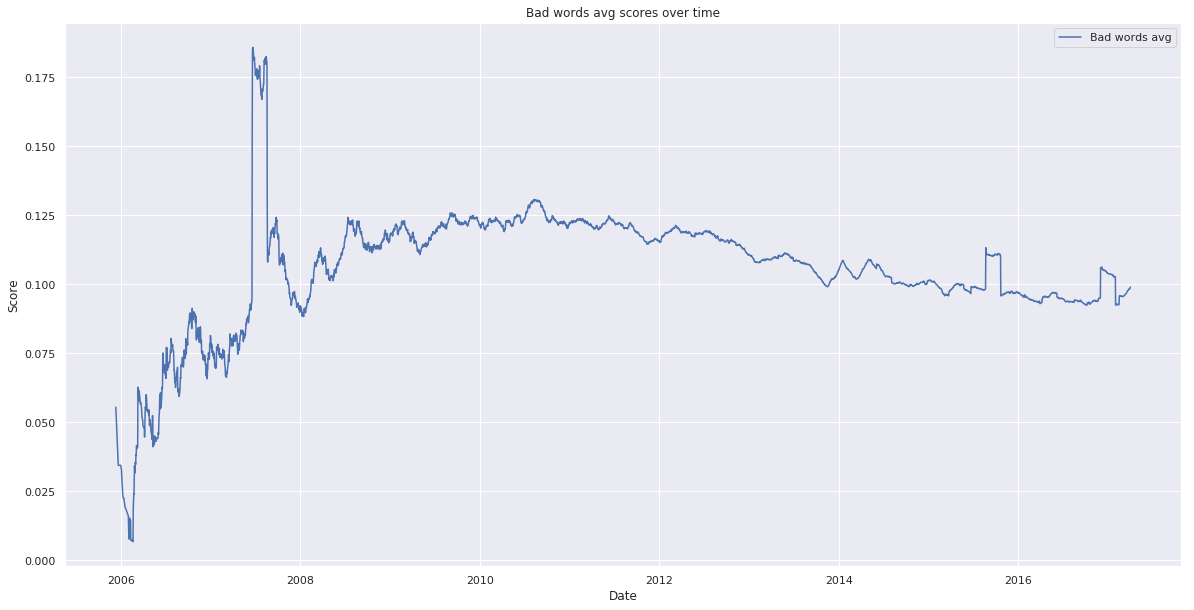

In [38]:
bw_plot_stat(bw_avg=True)

It is interesting to see that the number of bad words started to increase slowly from the creation of Reddit until around 2011. The metric then decreases until 2017. Overall, from 2009 to 2017, the metric is quite constant. During those years, the number of bad words per 100 messages is between 9 and 13.

We observe some spikes just before 2008 and also just before 2016 and in 2017. It is hard to make sense of those spikes. One hypothese is that some changes were made in the algorithms of Reddit to censor/delete messages which where vulgar or offensive and these changes were somehow more laxist for the censor criteria. Those spikes only appear for a very short amount of time. It is therefore highly possible that these come from algorithms tests that Reddit put in place.

We will now take a look at hate words.

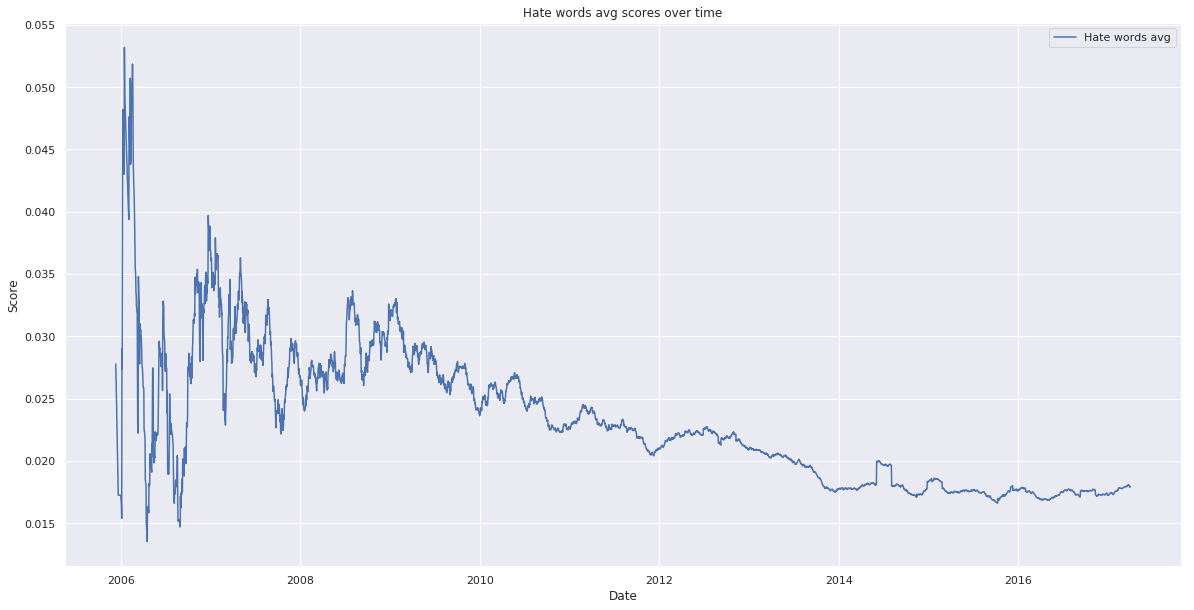

In [39]:
hw_plot_stat(hw_avg=True)

We observe that the data is very noisy this time, particularly until the year 2009. Even though the number of hate words per message has never been very high (always less than 6 hate words per 100 messages), the overall tendency is that the number of hate words decreases more and more with years passing. Many hypotheses can explain these observations. One of them is that people tend to not use less hate words. Another is that Reddit's hate words detection algorithm is becoming better and better or that moderators are doing a great job at filtering very offensive messages.

The list of hate words used for this plot is a little bit noisy. Therefore, we decided to see what happens with a refined list of hate words. We now take a look at the resulting plot below.

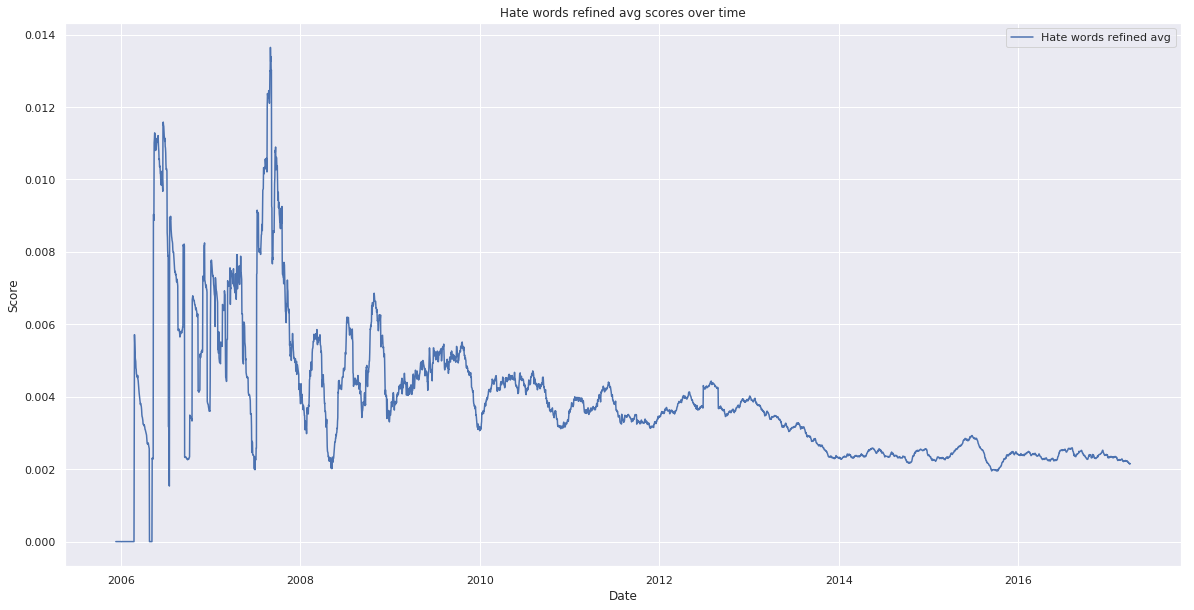

In [40]:
ref_hw_plot_stat(ref_hw_avg=True)

Again, the data is very noisy particularly until the year 2009. The number of hate words detected this time with the refined list is now even lower than before. The number of hate words per 100 messages is between 0 and 2. The same decreasing tendency as before is observed.

### Statistical analysis of NLP Metrics

We now dive deeper into the statistical analysis part of the project

##### Negativity, neutrality and positivity distributions

We take a look a the negativity, neutrality and positivity distributions. In this part, for each plot respectively, we remove the messages which had scores of zero (i.e. for the negativity plot, we discard all messages which had a negativity of 0). This way, we can have a better look at the distribution of negativity/neutrality/positivity for all negative/neutral/positive messages. Note however that these distributions are not representative of the distributions of negativity/neutrality/positivity among the whole dataset as we discard many messages.

In [41]:
nlp_full_sample = spark.read.load('../data/subreddit_nlp_full_0.001.parquet/')
nlp_sample = nlp_full_sample.sample(withReplacement=False, fraction=0.4, seed=0).toPandas()
nlp_sample = nlp_sample.drop(['id', 'subreddit', 'subreddit_id', 'creation_date', 'body', 'hw_ref_intensity'], axis=1)
nlp_sample.columns = ['neg', 'neu', 'pos', 'pol', 'subj', 'bw', 'hw', 'hw_ref']

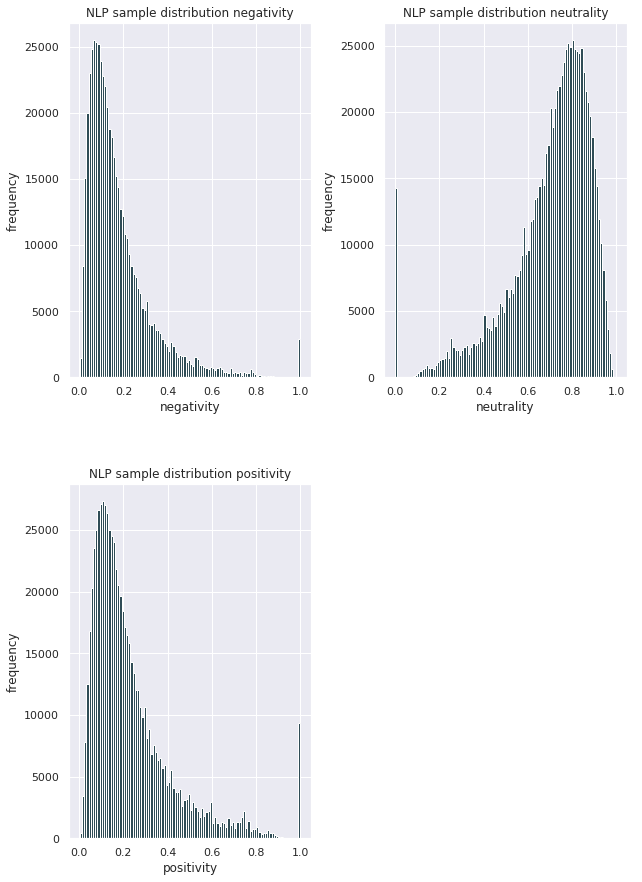

In [65]:
pc.plot_nlp_sample_distrib([nlp_sample], ['NLP sample distribution'])

The negativity and positivity distributions look very much alike. They look like skewed gaussian distribution. The majority of negative and positive messages respectively have low scores. One explanation is that when people write messages, only a few words will be negative or positive respectively and all the rest of the words will score as neutral. This also explains the look of the neutrality distribution where we can see that neutral messages have mostly a very high neutral score. Also, for all three distributions, we observe a spike. For the negativity and positivity distribution, this spike corresponds to very short messages with only negative or positive words respectively. Therefore these messages scores have value 1. Furthermore, these messages will have a neutrality score of 0, which explains the spike at 0 for the neutrality distribution.

### Analysis of Correlations between the Metrics

We now take a look at the correlations between the different metrics we use. As some of these metrics are computed as aggregation values (for instance, agreement score), we decided to analyze the correlations under two different angles: when the values are aggregated either per day or per subreddit.

#### Correlations between daily aggregates

In [43]:
# Load necessary data
nlp_n = pn.get_all_metrics(remove_outliers=False)
metrics = pd.concat([nlp_n, daily_agreement['agreement_factor'], daily_metrics['total_score']], axis=1, sort=True)
metrics['total_score'] = metrics['total_score'].apply(np.log)
metrics = metrics.dropna()

# Remove outliers assuming gaussian distribution
cleaned_metrics = metrics[(sp.stats.zscore(metrics) < 3).all(axis=1)]

Let's plot the distribution of each metrics to have an idea of how the data looks like.

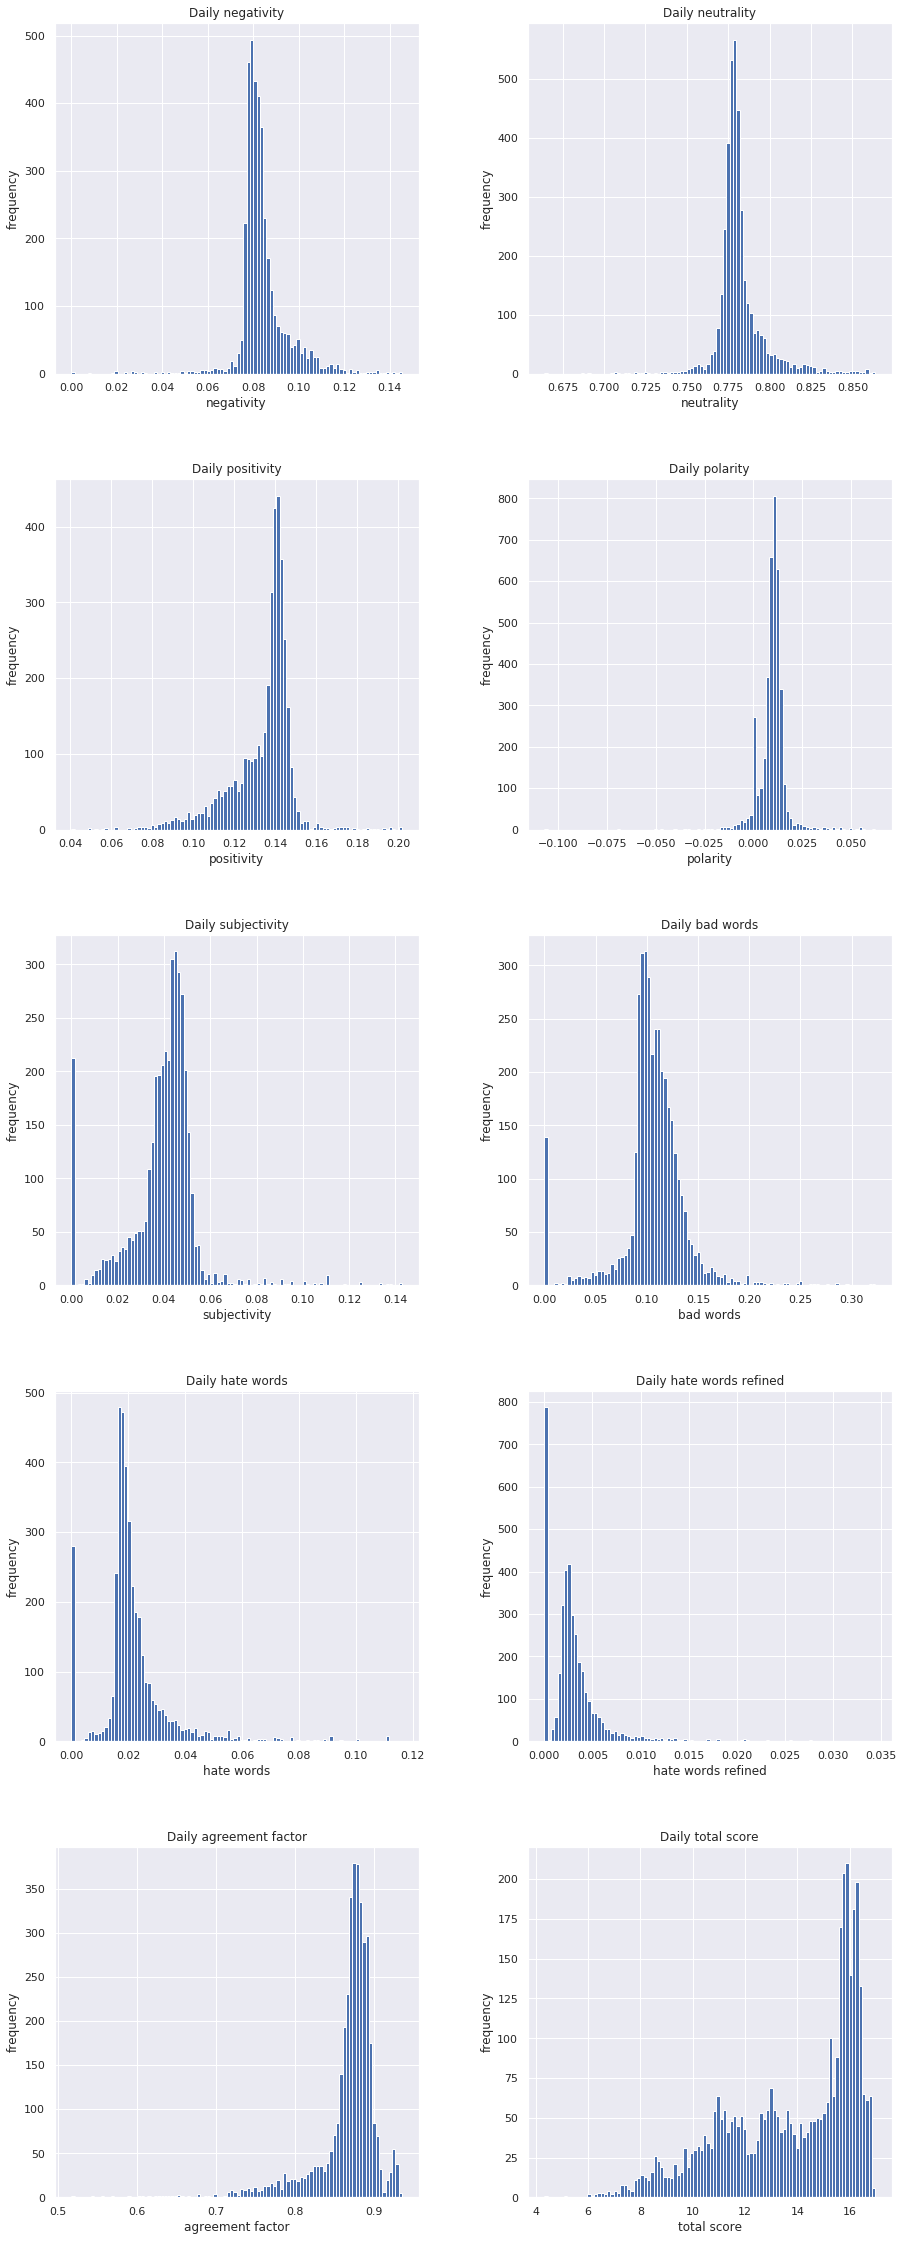

In [44]:
pc.plot_daily_distrib([cleaned_metrics], ['Daily'])

Let's take a look at the correlation matrices.

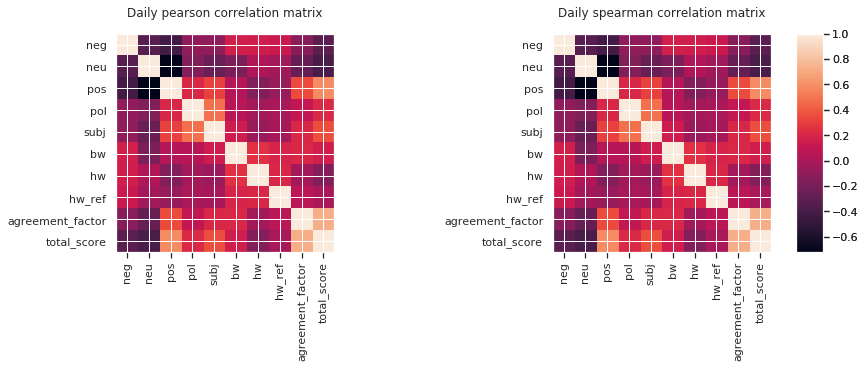

In [71]:
pc.plot_corr_mats([cleaned_metrics], 'Daily', ['pearson', 'spearman'])

The correlation matrices gives us an overview of the potential correlation we may expect. We already see that the agreement factor and the total score are highly positively correlated. This is expected as the agreement factor was calculated based on the total score.

The positivity and total score also seem to be positively correlated. The positivity and neutrality seem to be negatively correlated. This already mentioned earlier in the notebook that when neutrality goes down, it seems to be replaced by positivity and vice-versa.

The polarity and subjectivity metric also seem to be positively correlated. This could be because both metrics come from the TextBlob library and they may both rely on the same basis to compute their respective scores.

We now take a look at the scatter plots to have a better visualization of potential correlations.

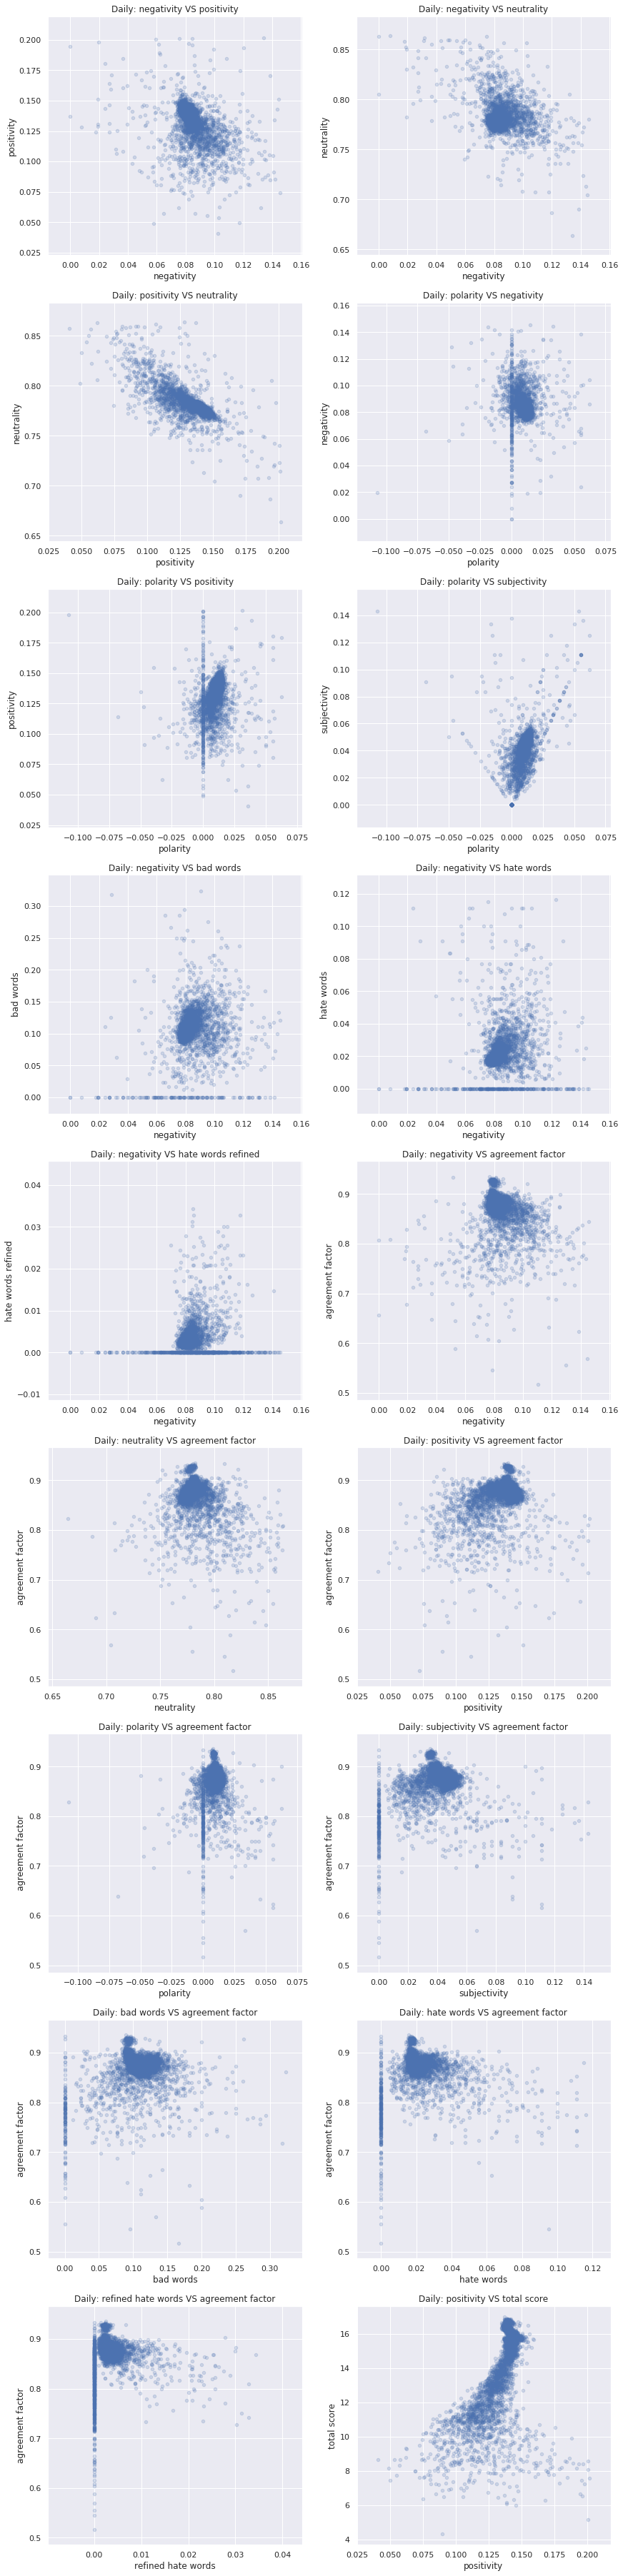

In [46]:
pc.plot_daily_metrics_full([cleaned_metrics], ['Daily'])

#### Correlations between subreddit aggregates

In [47]:
subreddit_agreement = spark.read.load('../data/subreddit_agreement.parquet').toPandas().set_index('subreddit')
subreddit_agreement.index = subreddit_agreement.index.map(str.lower)
subreddit_nlp = spark.read.load('../data/subreddit_nlp_full_0.001.parquet').drop('id', 'subreddit_id', 'creation_date', 'body', 'hw_ref_intensity')
subreddits_names = set(subreddit_agreement.index.values)
subreddit_nlp = subreddit_nlp.filter(func.col('subreddit').isin(subreddits_names))
subreddit_to_keep = subreddit_nlp.groupBy('subreddit').count()
subreddit_nlp = subreddit_nlp.join(subreddit_to_keep, on='subreddit', how='inner')
subreddit_nlp = subreddit_nlp.filter('count > 100').drop('count')
subreddit_nlp = subreddit_nlp.groupBy('subreddit').avg()
subreddit_nlp = subreddit_nlp.toPandas().set_index('subreddit')
subreddit_nlp.columns = ['neg', 'neu', 'pos', 'pol', 'subj', 'bw', 'hw', 'hw_ref']

In [48]:
subreddit_metrics = pd.merge(subreddit_agreement, subreddit_nlp, left_index=True, right_index=True).drop(['count', 'count_pos', 'count_neg'], axis=1)

# Remove outliers assuming gaussian distribution
subreddit_metrics_cleaned = subreddit_metrics[(sp.stats.zscore(subreddit_metrics) < 3).all(axis=1)]

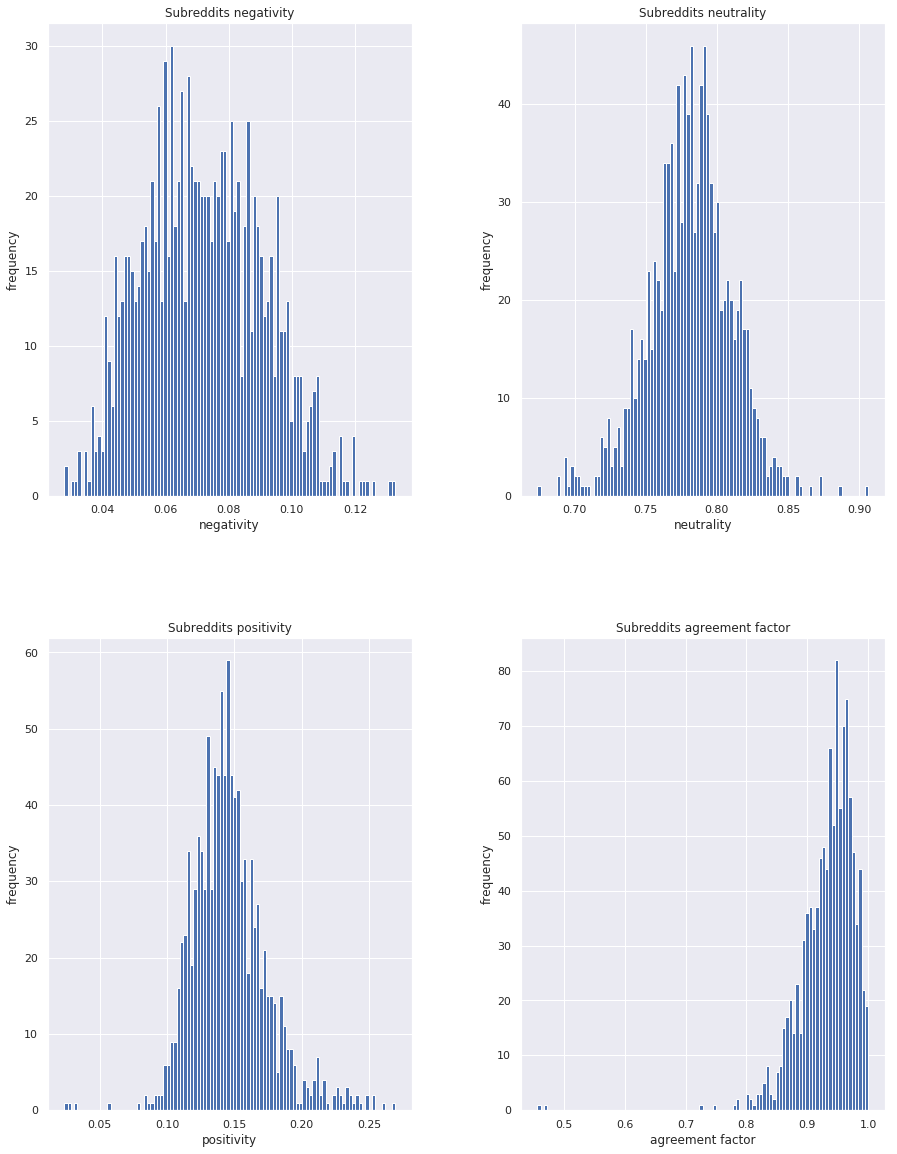

In [49]:
pc.plot_subreddit_distrib([subreddit_metrics_cleaned], ['Subreddits'])

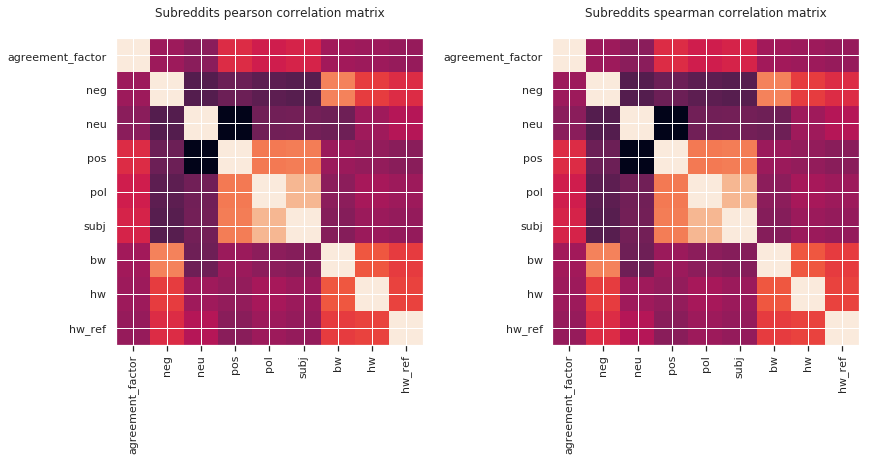

In [50]:
pc.plot_corr_mats([subreddit_metrics_cleaned], 'Subreddits', ['pearson', 'spearman'])

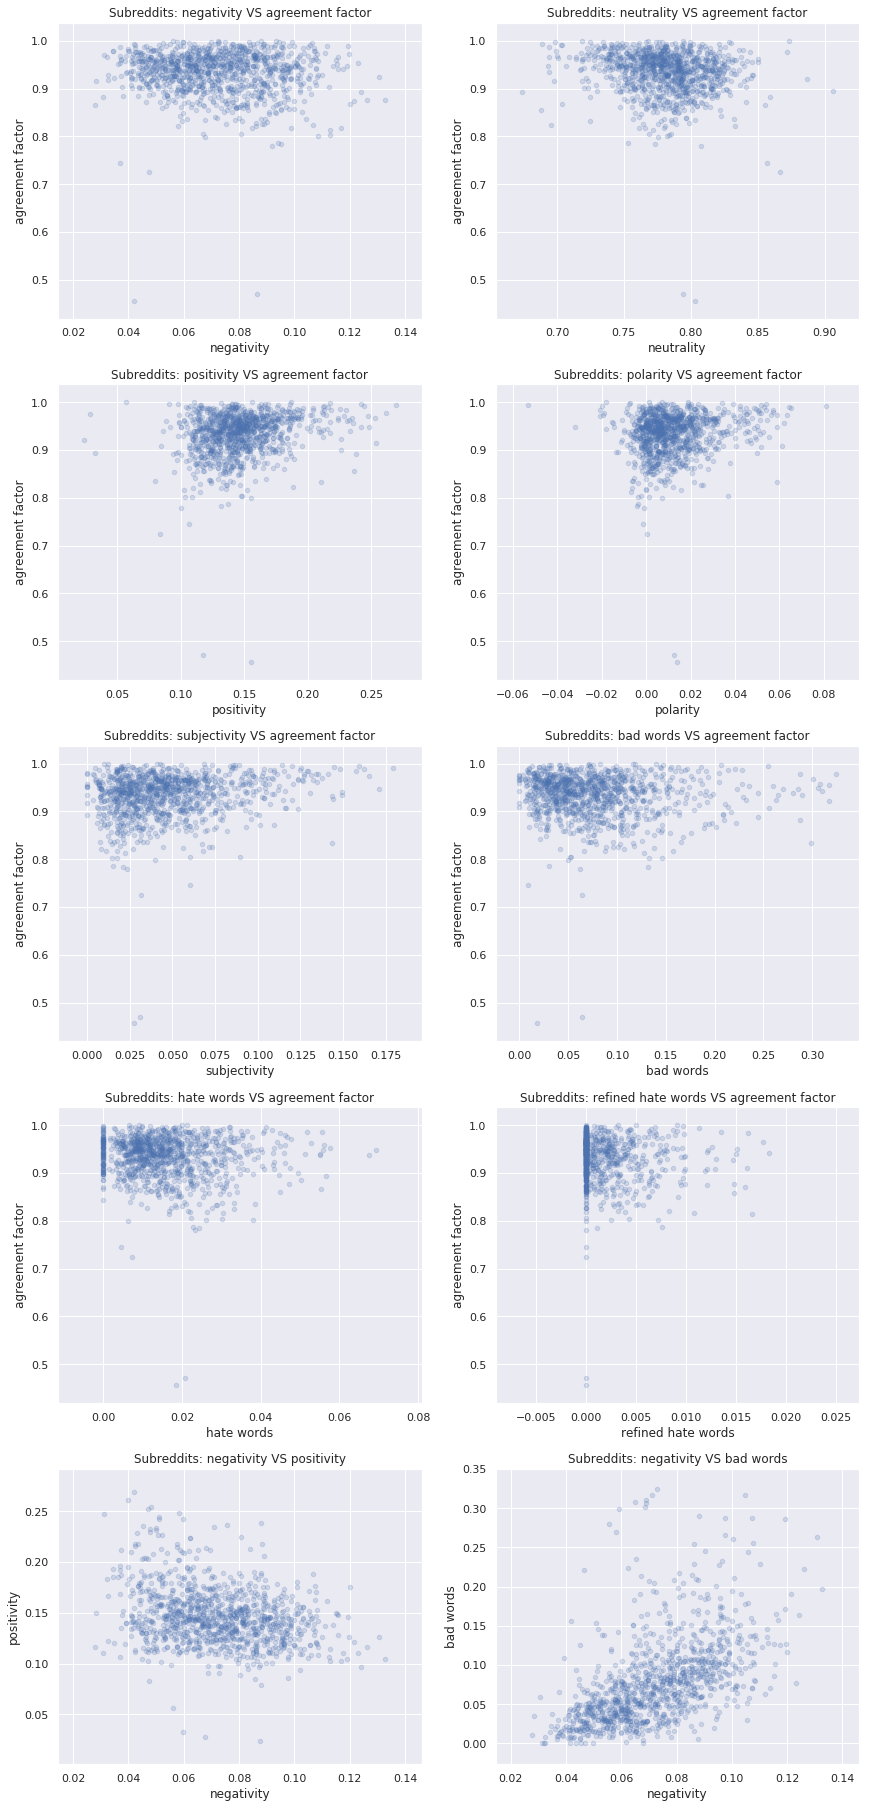

In [51]:
pc.plot_subreddit_metrics([subreddit_metrics_cleaned], ['Subreddits'])

## A Look at Reddit Communities

Now that we have a pretty good idea of how we can measure divisiveness, negativity and vulgarity, it is interesting to take a deeper dive into specific communities and sub-communities and see how these metrics compare. 

In order to do that, we initially compiled a list of communities related to a specific topic. This was done with the help of [/r/ListOfSubreddits](https://www.reddit.com/r/ListOfSubreddits/wiki/listofsubreddits) which provides an extensive list of active communities organized by topic. 

### Macro-Analysis of General Communities

First of all, we decided to extract 4 "macro communities" based on types of discussion. These

* **Politics**, which contains all subreddits linked to discussions about politics, political ideologies, political news, political candidates and so forth.
* **Sports**, another big group of commmunities linked to discussions on sports in general, a specific sport or a specific sports team.
* **Music**, related to genres of music, specific bands or general discussions on music
* **Video Games**, related to video games in general, to a subgenre of games, a specific game, game company or console.

First, we will analyze how the negativity and positivity metrics we computed earlier vary depending on the macro-communities chosen.

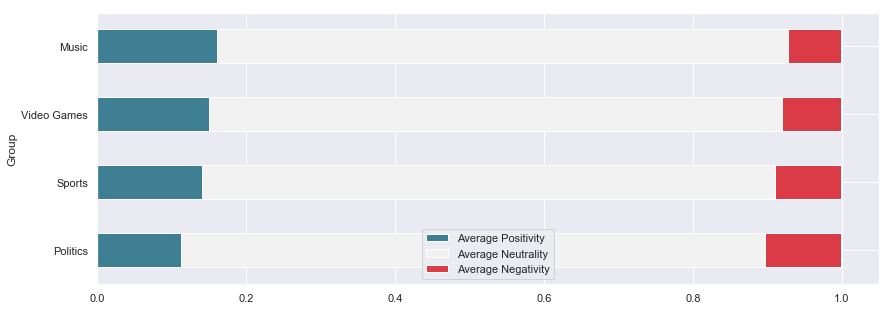

In [11]:
# Using Spark, get the mean positivity, negativity, neutrality, etc... for each "Group" (= macro-community)
nlp_per_community_group_avg_df = nlp_per_community.groupBy(func.col('Group')).mean().toPandas().set_index('Group').rename(columns={
    'avg(Negativity)': 'Average Negativity', 
    'avg(Positivity)': 'Average Positivity', 
    'avg(Neutrality)': 'Average Neutrality',
    'avg(Vulgarity)': 'Average Vulgarity'
})

# Plot the neutrality, positivity and negativity of each Group
_ = nlp_per_community_group_avg_df[['Average Positivity', 'Average Neutrality','Average Negativity']].sort_values('Average Positivity').plot(
    kind='barh', 
    stacked=True, 
    colormap=ListedColormap(sns.diverging_palette(220, 10, sep=80, n=3)), 
    figsize=(14,5)
)

From the chart above, we can see that, even though most of the discussion is neutral, Politics is simultaneously the most negative and least positive type of discussion. Let's look now look at vulgarity and agreement as well.

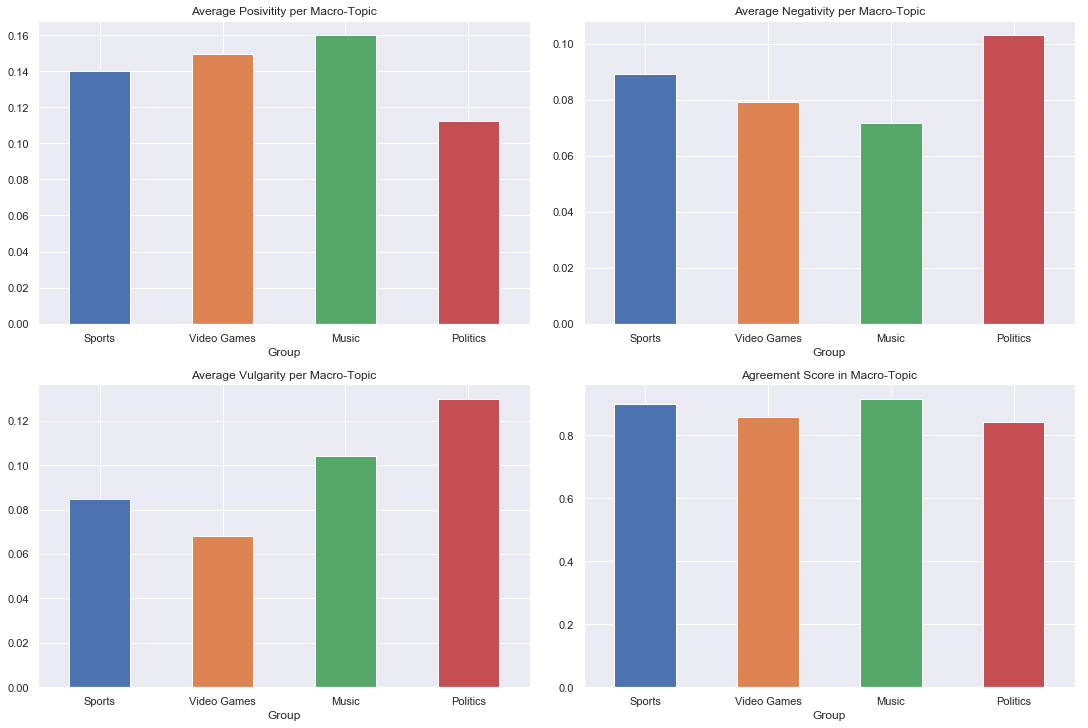

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10), constrained_layout=True)

axes[0, 0].set_title("Average Posivitity per Macro-Topic")
axes[0, 1].set_title("Average Negativity per Macro-Topic")
axes[1, 0].set_title("Average Vulgarity per Macro-Topic")
axes[1, 1].set_title("Agreement Score in Macro-Topic")

_ = nlp_per_community_group_avg_df['Average Positivity'].plot(
    kind='bar', ax=axes[0, 0], rot=0
)

_ = nlp_per_community_group_avg_df['Average Negativity'].plot(
    kind='bar', ax=axes[0, 1], rot=0
)

_ = nlp_per_community_group_avg_df['Average Vulgarity'].plot(
    kind='bar', ax=axes[1, 0], rot=0
)

_ = agreement_per_community['agreement_factor'].reindex(nlp_per_community_group_avg_df.index).plot(
    kind='bar', ax=axes[1, 1], rot=0
)

The data we observed seems to be confirmed here. In addition to being the least positive / most negative category, politics is also the one with the most vulgarity and the smallest amount of agreement.

In [17]:
groups = ['Politics', 'Sports', 'Music', 'Video Games']
metrics = ['nltk_negativity', 'nltk_positivity']

In [18]:
# Fetch all comments and their metric for each group (warning: expensive computation)
group_metrics = create_group_metrics(groups=groups, metrics=metrics) 

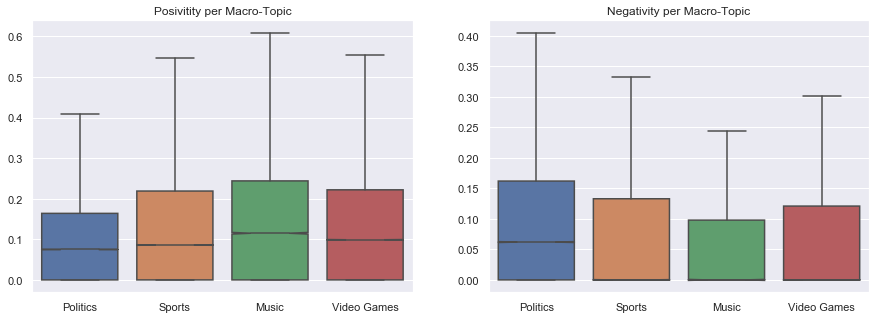

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axes[0].set_title("Posivitity per Macro-Topic")
axes[1].set_title("Negativity per Macro-Topic")

sns.boxplot(data=group_metrics['nltk_positivity'], ax=axes[0], showfliers=False, notch=True)
sns.boxplot(data=group_metrics['nltk_negativity'], ax=axes[1], showfliers=False, notch=True)

axes[0].set_xticklabels(groups)
_ = axes[1].set_xticklabels(groups)

Here, we plot the median and quartile values for what we observed above. Since we have a lot of data, the confidence interval is very narrow. However, we have to remember that this is ran on a subsample (at least the negativity, positivity and vulgarity metrics), as it was not possible to run them on the entire dataset for lack of time / computation power / optimization.

### Deeper Dive into Political Communities

Here, the idea is the same except that we look at sub-categories inside politics. 

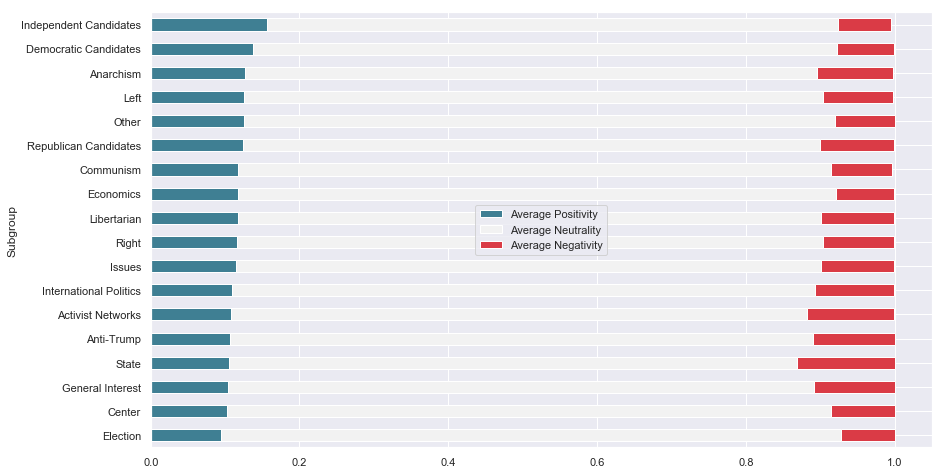

In [16]:
# Using Spark, get the mean positivity, negativity, neutrality, etc... for each "Subgroup" (= group of subreddits)
nlp_per_community_subgroup_avg_df = nlp_per_community.filter(func.col('Group') == func.lit('Politics')).groupBy(func.col('Subgroup')).mean().toPandas().set_index('Subgroup').rename(columns={
    'avg(Negativity)': 'Average Negativity', 
    'avg(Positivity)': 'Average Positivity', 
    'avg(Neutrality)': 'Average Neutrality',
    'avg(Vulgarity)': 'Average Vulgarity'
})

# Plot the neutrality, positivity and negativity of each Subgroup
_ = nlp_per_community_subgroup_avg_df[['Average Positivity', 'Average Neutrality','Average Negativity']].sort_values('Average Positivity').plot(
    kind='barh',
    stacked=True,
    colormap=ListedColormap(sns.diverging_palette(220, 10, sep=80, n=3)), 
    figsize=(14,8)
)

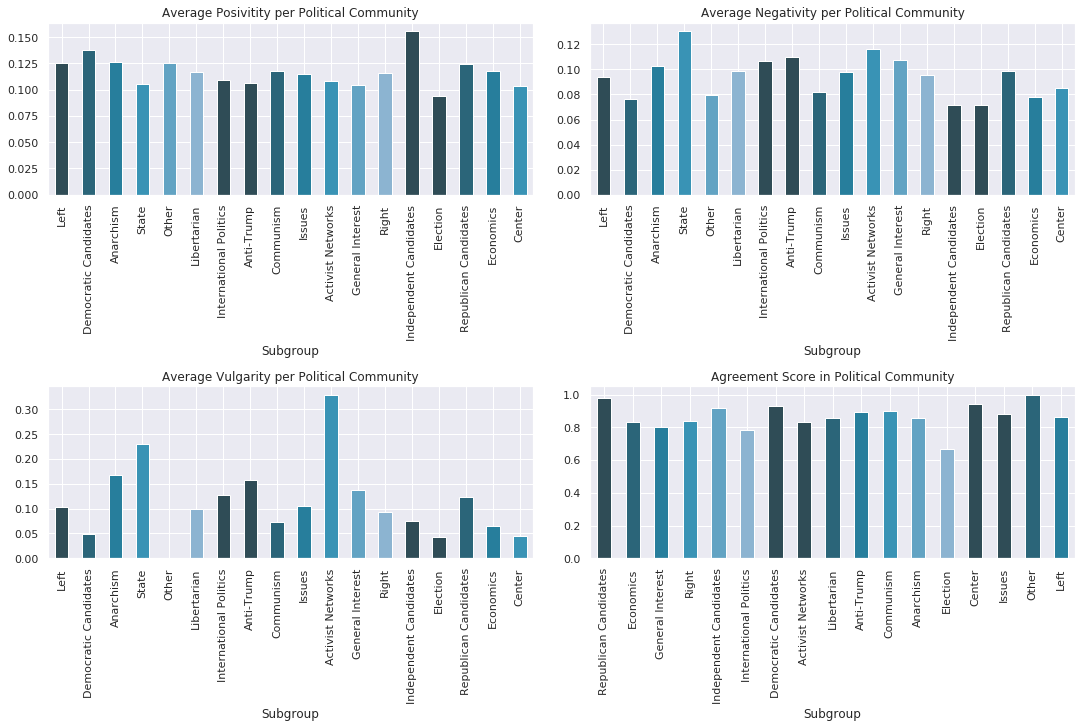

In [61]:

sns.set(palette="PuBuGn_d")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10), constrained_layout=True)

axes[0, 0].set_title("Average Posivitity per Political Community")
axes[0, 1].set_title("Average Negativity per Political Community")
axes[1, 0].set_title("Average Vulgarity per Political Community")
axes[1, 1].set_title("Agreement Score in Political Community")

_ = nlp_per_community_subgroup_avg_df['Average Positivity'].plot(
    kind='bar', ax=axes[0, 0], rot=90
)

_ = nlp_per_community_subgroup_avg_df['Average Negativity'].plot(
    kind='bar', ax=axes[0, 1], rot=90
)

_ = nlp_per_community_subgroup_avg_df['Average Vulgarity'].plot(
    kind='bar', ax=axes[1, 0], rot=90
)

_ = agreement_per_subgroup['agreement_factor'].reindex(agreement_per_subgroup.index).plot(
    kind='bar', ax=axes[1, 1], rot=90
)

There are several noteworthy things here. First, the communities related to independent candidates in the 2016 election seem to have the highest positivity. Of course, the sample is too small to provide a general, but it is an interesting note.

Secondly, the most vulgar of all subreddits are those related to activist networks. This includes /r/Anonymous /r/AnonOps, /r/OccupyWallStreet, /r/IsraelExposed, and others. Given that these communities often promote more radical actions and more violently, this is not necessarily a surprise. There is a similar argument for Anti-Trump and Anarchism subreddits though, that we see are fairly high on both vulgarity and negativity.

Finally, we note that subreddits dedicated to a candidate have very high agreement factors, which can hint that these communities, just like The_Donald, are echo chambers regardless of political affiliation.

In [62]:
subgroups = ['Independent Candidates', 'Democratic Candidates', 'Anarchism', 'Left', 'Republican Candidates',
            'Communism', 'Libertarian', 'Right', 'International Politics', 'Activist Networks',
          'Anti-Trump', 'Center']
metrics = ['nltk_negativity', 'nltk_positivity']

In [63]:
# Fetch all comments and their metric for each group (warning: expensive computation)
subgroup_metrics = create_subgroup_metrics(subgroups=subgroups, metrics=metrics) 

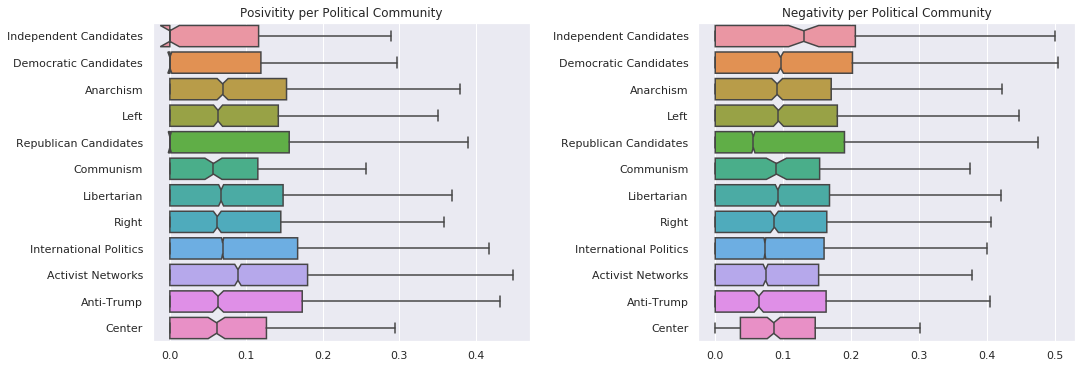

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), constrained_layout=True)

axes[0].set_title("Posivitity per Political Community")
axes[1].set_title("Negativity per Political Community")

sns.boxplot(data=subgroup_metrics['nltk_negativity'], ax=axes[0], showfliers=False, orient='h', notch=True)
sns.boxplot(data=subgroup_metrics['nltk_positivity'], ax=axes[1], showfliers=False, orient='h', notch=True)

axes[0].set_yticklabels(subgroups, rotation=0)
_ = axes[1].set_yticklabels(subgroups, rotation=0)

### Looking at individual Subreddits

#### Highest Agreement

Just like we did in Milestone 2, we tried here to visualize which subreddits are the most extreme for our metrics. We previously found out that the communities with lowest agreement factor included /r/news, /r/politics, videogames-related communities and subreddits related to cities.

Now looking at the same metric on the other side of the scale, we can see that /r/The_Donald and /r/4chan both have very high levels of agreement. This supports the hypothesis that these communities are big echo chambers where people hardly deviate from the herd opinion.

In [20]:
subreddit_agreement[subreddit_agreement['count'] > 50000][['count', 'agreement_factor']].sort_values('agreement_factor', ascending=False).head(10)

,count,agreement_factor
subreddit,,
JUSTNOMIL,72471,0.997392
RWBY,68210,0.994356
teenmom,96030,0.989639
exmormon,66736,0.989241
fatlogic,85095,0.986674
The_Donald,1362473,0.984966
PrequelMemes,60820,0.984166
fireemblem,52421,0.983327
stevenuniverse,58174,0.979768


#### Least Positive / Most Negative

Looking at the least positive and most negative subreddits, we find that these are for the most part the same. Again, we find the usual culprits /r/news and /r/worldnews. We can also note the presence of /r/conspiracy and /r/The_Donald in at least one of the lists.

In [30]:
nlp_per_subreddit = spark.sql("""
SELECT 
    subreddit,
    COUNT(*) AS count,
    AVG(nltk_negativity) AS negativity,
    AVG(nltk_positivity) AS positivity,
    AVG(nb_hw_matches) AS vulgarity
FROM nlp
GROUP BY subreddit
""").toPandas().set_index('subreddit')

In [37]:
nlp_per_subreddit[nlp_per_subreddit['count'] > 5000][['count', 'positivity']].sort_values('positivity', ascending=True).head(10)

,count,positivity
subreddit,,
news,20839,0.102884
technology,11210,0.106285
worldnews,31250,0.108674
explainlikeimfive,7810,0.109257
conspiracy,5049,0.109273
science,5845,0.111152
canada,5813,0.111200
asoiaf,5259,0.112603
TumblrInAction,5850,0.112789


In [39]:
nlp_per_subreddit[nlp_per_subreddit['count'] > 5000][['count', 'negativity']].sort_values('negativity', ascending=False).head(10)

,count,negativity
subreddit,,
news,20839,0.116782
worldnews,31250,0.108632
MMA,8078,0.108582
TumblrInAction,5850,0.106050
WTF,32962,0.105821
politics,47815,0.103525
conspiracy,5049,0.102115
The_Donald,14510,0.099455
fffffffuuuuuuuuuuuu,7698,0.098332


#### Least Positive / Most Negative

On the other side of the spectrum, looking at the most positive (least negative) communities yield some very interesting results. First, we note the presence of /r/gonewild, an NSFW subreddit. In fact, digging deeper we were able to find many other NSFW subreddits ranking very highly on the positive scale.

Besides this, we note the presence of some very wholesome communities:

* **/r/Random_Acts_Of_Amazon** is about sending strangers Amazon packets to make their day. 
* **/r/aww** is about pictures of cute animals
* **/r/trees** is about a special kind of trees that you can smoke
* **/r/pokemontrades** is about, well, pokemon trades

Looking at another list which is not displayed here, we found a lot of subreddits in the form of "Random_Acts_Of_(Something)" as very positive. Same for pokemon-related subreddits.

In [47]:
nlp_per_subreddit[nlp_per_subreddit['count'] > 5000][['count', 'positivity']].sort_values('positivity', ascending=False).head(10)

,count,positivity
subreddit,,
gonewild,10589,0.333222
Random_Acts_Of_Amazon,8004,0.275170
pokemontrades,7320,0.244319
friendsafari,7042,0.235170
electronic_cigarette,7536,0.188835
aww,10078,0.167386
GlobalOffensiveTrade,5961,0.164536
teenagers,8169,0.163981
trees,16537,0.163091


In [44]:
nlp_per_subreddit[nlp_per_subreddit['count'] > 5000][['count', 'negativity']].sort_values('negativity', ascending=True).head(10)

,count,negativity
subreddit,,
friendsafari,7042,0.017278
buildapc,8087,0.045673
pokemontrades,7320,0.050960
electronic_cigarette,7536,0.054318
GlobalOffensiveTrade,5961,0.059628
RocketLeagueExchange,5291,0.061547
Random_Acts_Of_Amazon,8004,0.062162
pcmasterrace,17146,0.062792
Android,7677,0.062832


#### Most / Least Vulgar

Among the most vulgar subreddits, we find a lot of subreddits that we've seen before. 

* **/r/gonewild** is interestingly at the same time very positive and very vulgar. 
* On the other hand, **/r/TumblrInAction** is the most vulgar of this list and also present on the list of most negative subreddits. Looking at the content of the subreddit, it looks like it is a community of people insulting regular users of tumblr, hence the results found here.

In [49]:
nlp_per_subreddit[nlp_per_subreddit['count'] > 5000][['count', 'vulgarity']].sort_values('vulgarity', ascending=False).head(10)

,count,vulgarity
subreddit,,
TumblrInAction,5850,0.034188
gonewild,10589,0.031353
news,20839,0.030328
videos,30226,0.030305
reddit.com,11748,0.030048
baseball,6566,0.028785
fffffffuuuuuuuuuuuu,7698,0.028709
conspiracy,5049,0.028322
WTF,32962,0.028002


### Average Participation of Users

In this section, we try to understand the reasons behind the almost constant increase in agreement that we found in milestone 2. One of the hypothesis we made was that people are more "clustered" into communities with the same opinion (= echo chambers). In. order to confirm this, we looked at the average number of subreddits a user participates in per month (where "participating" means writing at least one comment).

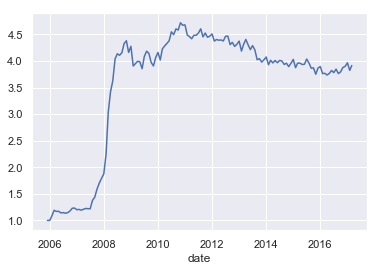

In [9]:
monthly_contribs['date'] = monthly_contribs.apply(lambda row: dt.date(int(row.year), int(row.month), 1), axis=1)
_ = monthly_contribs.sort_values('date').set_index('date')['avg_nb_sub'].plot.line()

If we look at mid-2008 and after, we see that there is a constant decrease in this number. In fact, the 2016 value is more than 20% less than the peak value in 2011. This could provide support for the fact that users are more clustered.

Note that we can ignore the initial years as the concept of subreddit did not appear immediately with the platform. Initially, all discussions happened in the same community, and later split into multiple sub-communities.

One hypothesis that could void this result is if, at the same time, users would now write less comments in general. Then, it is clear that such a result would follow. However, this is not the case, as we can see in the following plot that users actually write on average more messages than they used to. 

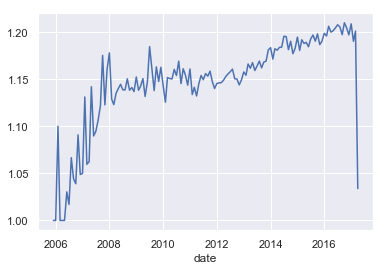

In [15]:
messages_per_user = spark.sql("""
    SELECT AVG(nb_com) AS avg_nb_com, month, year FROM (
        SELECT 
            author, 
            YEAR(created) AS year, 
            MONTH(created) AS month, 
            COUNT(id) AS nb_com 
        FROM comments
        WHERE author != '[deleted]' AND author != '[removed]'
        GROUP BY author, YEAR(created), MONTH(created)
    )
    GROUP BY month, year
""").toPandas()

messages_per_user['date'] = messages_per_user.apply(lambda row: dt.date(int(row.year), int(row.month), 1), axis=1)
_ = messages_per_user.sort_values('date').set_index('date')['avg_nb_com'].plot.line()

**Important Note** - this last result is based on the subsample, as we did not have time to run this computation on the cluster. For this reason, the y-axis is not to scale. We also have to take it with a grain of salt, but we decided to include it as it gives us a general idea and, in the case of the previous graph, the full computation yielded a similar result than the sub-sample.

# Topics during the 2016 election

It is widely accepted and recognized in the political sphere that the U.S. 2016 presidential election greatly divided the U.S. citizens. As early as January 2016 [journalists](https://www.washingtonpost.com/politics/a-divided-country-gets-a-divisive-election/2016/01/09/591bfccc-b61f-11e5-a842-0feb51d1d124_story.html?noredirect=on&utm_term=.54c240a270e9) already reported the rethoric used by the various presidential candidates was unusually violent and agressive, resulting in a division among the opinions of the american people. A division which kept on growing through the year as the presidential candidates were striked by diverse controversies. 

Many subreddits serves as a hub for internet users wanting to voice their support for the candidate they wished would win. This provides us some natural aggregation of the opinions of people supporting each side of the election. [r/The_Donald](https://www.reddit.com/r/The_Donald) and [r/hillaryclinton](https://www.reddit.com/r/hillaryclinton) were the main subreddits for reddit users standing respectively for the Republican and the Democrat candidate. In order to observe the divisiveness, we chose to take a more specialized look into what were the most discussed topics in each community the week preceding the election day. The goal would be to discern through the topic discussed in each community how the rhetoric of the candidate were apprehended, and how the internet community dealt with this controversial election.


### Methodology: LDA

Latent Dirichlet Allocation (LDA) is the unsupervised clustering method we choose to model Reddit discussions topics. Given a corpus of documents, LDA assumes that each document is the product of a mixture of a certain number of topic. Using this algorithm we can infer what might be the subjects discussed in the documents' collection.

In our case, we chose the documents to be directly reddit's comments, as it is the smallest coherent piece of information from a discussion thread. Some classic natural language preprocessing has to be done for LDA to work properly: each comment was first tokenized, then cleaned of any english stop words and finally lemmatized. Once applied to the dataset, we observed that more preprocessing had to be done in order to remove idiosyncracies of Reddit:

* Comments with a low score do not represent opinion which was appreciated enough by the community. We decided to remove each comment whose score was lower than 10.

* Short answers in threads do not bring much information to the discussion. We thus removes all comments whose length was below 50 character. As a beneficial side effect, this part of preprocessing also removes comments which vere deleted or removed by moderators.

* Some subreddits deploy special program disguised as user called "bots" which can serve many purpose, wether it is automatic moderation or helping the user with referencing. As the textual content of bots comments is mostly automatic, it does not give any information on the topic. Bots' comments even pollute topics modelled by LDA if considered since one both will likely spur the same textual content each time it is invoked. For those reason, we removed comments obviously authored by a bot.

* Users tend to often link outside sources or other reddit comments. As URLs does not mix well with natural language processing, they had to be removed.

LDA can then be applied on the collection of preprocessed Reddit comments. Among the number of topics and words per topic, the algorithm can take also two other parameters: the document concentration (alpha), and the topic concentration (beta). 

The alpha parameter is proportional to how many topics are mixed together to produce a document. In the context of Reddit's comments, it is unlikely that a single comment mentions a lot of topics, as it is a rather short piece of text and will likely focus on the subject of the thread. Thus a small value of alpha should be chosen.

The beta parameters is inversely proportionnal to how much the topics are compromised of the same words.In other words, a low value of beta would trigger LDA to produce topics which do not share many identical words.

Through various tests, it was found that 8 topics of 5 words each with a 0.1 value for beta and 0.025 for alpha produced the best results for our purpose.

## Topic analysis by subreddits

### r/The_Donald

In [4]:
def display_topics(topics):
    tops = topics.select('topic').collect()
    for i in range(len(tops)):
        print("Topic %d: %s"%(i+1, tops[i][0]))
        
trump_lda = spark.read.load('../data/trump_lda_result.parquet/')
display_topics(trump_lda)

Topic 1: fearless donald fucking last time
Topic 2: cooking spirit propaganda traitor comey
Topic 3: clinton hillary cuck email child
Topic 4: pedophile corrupt epstein know shit
Topic 5: trump energy take train vote
Topic 6: deleted weiner laptop archive watch
Topic 7: vote trump elite thread year
Topic 8: hero clinton podesta hillary rich


Upon quick inspection, what was discussed the week before the election seems to be a rather erratic aggregation of diverse words. Each topic mention at least one person, often the name of the two presidential candidates. However other terms seems to not be making much sens in the context of the election. Fortunately, an in-depth analysis of the topics reveal some interesting insight to what was discussed by the redditors supporting Donald Trump:

* **"fearless donald fuckin last time"**: Supporters of Donald Trump have often qualified the then republican candidate to be _fearless_ which explains the occurence of the two first words. It is harder however to connect the last three words to this topic, as one swear word and two rather common terms do not apport much meaning to the _fearless donald_ revered by The_Donald's users.



* **"cooking spirit propaganda traitor comey"**: Two subtopics are actually present within this list of words. "_cooking spirit_" refers to an invitation by mail to John Podesta, Hillary's 2016 campaing chairman, to take part in a "Spirit cookinkg" dinner organised by Marina Abramović. This information was part of the leaked emails from Hillary Clinton and associates. [This dinner got soon exagerated by conspiray theorists as being something of satanist content](https://en.wikipedia.org/wiki/Marina_Abramović#Controversy). On the other hand, "propaganda traitor comey"  seems to refer to the then FBI director James Comey, which oversaw the investigation on Hillary Clinton's actions that led to the famous e-mails leak. At the end of the investigation, Comey determined that the action of Clinton did not deserve any penal sentence. As Trump was fond of the idea of locking up Hillary behind the bar for the whole e-mail scandal, the decision of Comey might have been perceived by r/The_Donald as treaterous or as a democrat led propaganda. It is possible that redditors linked the two events together, as the spirit cooking scandal was revealed through the emails' leak affair.



* **"clinton hillary cuck email child"**: While the _clinton hillary email_ part of the topic is easily interpretable, _child_ might be a reference to [the Pizzagate conspiracy theory](https://en.wikipedia.org/wiki/Pizzagate_conspiracy_theory) which posited that the e-mail leaked revealed clues about a child-sex trafficking ring established in Washington D.C. Lastly, "cuck" does not seem to be linked directly to pizzagate or the e-mails, and could be a byproduct of the common vocabulary and terminology used through discussions on r/The_Donald.



* **"pedophile corrupt epstein know shit"**: The named entity of the topic this time is someone named _Epstein_. Considering the other words, this surely refers to Jeffrey Epstein, billionaire and former top donator of the democratic party who was [sentenced to jail for underage girl prostitution in 2008](https://en.wikipedia.org/wiki/Jeffrey_Epstein#Criminal_proceedings). Rephrasing a bit the topic would give us "Pedophile and corrupt Jeffrey Epstein knows shit". It may be possible that this topic stems from discussions theorizing Epstein would be linked to the Pizzagate conspiracy.



* **"trump energy take train vote"**: The _trump train_ is a metaphor used by Trump's supporters which represent the [swarm of great ideas](https://www.urbandictionary.com/define.php?term=The%20Trump%20Train) the New York businessman came up with during his campaign. To _take_ such a train would mean to be on board with Trump's idea, and be willing to _vote_ for him.


* **"deleted weiner laptop archive watch"**: As with Jeffrey epstein, the mention of someone named _weiner_ helps us there understanding what those five words mean together. Anthony Weiner was a former U.S. congressman whose career came to an end after [scandals surrounding sex photos he would send on twitter to woman](https://en.wikipedia.org/wiki/Anthony_Weiner#Sexting_scandals). He was the husband of Human Abedin which was the Vice Chair of Hillary's 2016 campaign. Weiner [_deleted_ his twitter account after exposure of one of his sexting_scandal](https://nypost.com/2016/08/29/anthony-weiner-deletes-twitter-amid-new-sexting-scandal/). As a result of this scandal, his _laptop_ was seized by the FBI and e-mails contained in the computer were informations that led James Comey to reopen the investigation on Hillary Clinton's mail eleven days before the election. _Archive_ could be referring to the archives of Clinton's email, while _watch_ could indicate that inspecting the email would give more evidence for incriminating the democrat politician, but it is a bit far-fetched. 


* **"vote trump elite thread year"**: _vote trump elite_ might constitutes an authority argument for Trump supporter to convince other people to vote for the New Yorker businessman. "The elite vote for Trump" might be the formulation used, which would imply that someone voting for Donald Trump is part of the _elite_.


* **"hero clinton podesta hillary rich"**: John _Podesta_ is mentioned with _Hillary Clinton_, however the terms _hero_ and _rich_ do not seem to give a precise clue as to how are the campaign chairman and the democratic candidate discussed.


In conclusion, Trump supporter's discussion seemed to focus on two main axis the week preceding the election: Scandals and conspiracy surrounding Trump's opponent, and gloryfing Trump, his actions and words. 



#### r/hillaryclinton

In [5]:
hillary_lda = spark.read.load('../data/hillary_lda_result.parquet/')
display_topics(hillary_lda)

Topic 1: romney markets biggest cake website
Topic 2: happening dead wikileaks completely energy
Topic 3: hillary vote trump going election
Topic 4: cosponsored already children total picture
Topic 5: emails clinton trump party used
Topic 6: believe clinton thanks trump campaign
Topic 7: polls gotv voting tomorrow shit
Topic 8: trump state model polls poll


Just like in The_Donald LDA analysis, "hillary", "clinton" and "trump" are common words in the topics which come as no surprise considering the context. Although less coherent than the topics from r/The_Donald, in-depth analysis of the r/hillaryclinton topics gives us a good insight to what was mattering Reddit users supporting the former first lady:

* **"romney markets biggest cake website"** Mitt _Romney_, republican politician and Oboma opponent in the 2012 election, [was positively viewed by Hillary's supporter](https://www.reddit.com/r/hillaryclinton/search?q=romney&restrict_sr=1&sort=top) for stating he would not vote for Trump. Unfortunately, links can hardly be made with _markets biggest cake website_ regarding either Mitt Romney or Hillary Clinton.


* **"happening dead wikileaks completely energy"**: A possible rephrasing or interpretation of this topic could be "_Wikileaks happening completely_ killed _energy_", or "The _energy_ is _completely dead_ because what is _happening_ with _Wikileaks_", whatever the choosen combination of word, this topic might very likely indicates what were Hillary's supporter thought about the leaked e-mails scandal: it negatively impacted Hillary's campaing energy. At the time it was already public knowledge that [Wikileaks played a crucial role in leaking the democratic candidate mails](https://wikileaks.org/clinton-emails/?q=iraq%7Cbaghdad%7Cbasra%7Cmosoul).


* **"hillary vote trump going election"**: This topic likely represents simple discussion about the upcoming election, which was happening in less than a week. Both candidates are mentioned, with _going_, _vote_ and _election_.


* **"cosponsored already children total picture"**: The farthest evidence of organisation "_cosponsored_" by Clinton that we could find was this [post about Hillary support of the LGBT+ community](https://www.reddit.com/r/hillaryclinton/comments/4xw1vr/a_brief_and_incomplete_timeline_of_hillarys/). The other terms are unforutnately too common in the context of the election in order to draw any conclusion.


* **"emails clinton trump party used"**: The subject here seems to be again _clinton_'s _emails_, this time the words seems to indicate that Hillary's supporter condemned _Trump_'s _party_ for _using_ this scandal. This gives us more proof that the redditors from r/hillaryclinton were displeased about the whole e-mail investigation.


* **" believe clinton thanks trump campaign"**: Those words could have many different interpretation together. Are the reddit user's thankful for clinton campaign? Do they _believe_ in _Clinton_'s _campaign_ but somehow are _thanking_ _Trump_? No definitive conclusion can be made in this case.


* **"polls gotv voting tomorrow shit"**: The most interesting term in this topic, is [_gotv_](https://blog.everyaction.com/what-is-gotv-anyway), which is a known political acronym for "Get Out To Vote". It characterizes the last stage of an election campaing in which the people are encouraged to go to the urns. The imminent term _tomorrow_ and _voting_ coupled to _gotv_ seems to imply some urgency on the matter from Clinton's supporters.


* **"trump state model polls poll"**: With a double occurence, this topic seems tied to some dicussions about the _polls_. [Most polls were predicting a win for Clinton](https://www.realclearpolitics.com/epolls/latest_polls/president/) the days preceding the election. The other three terms might be attribute linked to polls, like discussions on which _state_ the _polls_ indicate to be obtained by _Trump_, or discussions on which _model_ the _polls_ are built on to criticize their credibility for example.

Although less easily interpretable than the topics from r/The_Donald, the topics from r/hillaryclinton allow us to picture the mindset from the ex first lady supporters. We get to see their point of view of the e-mail affair, while we can observe their anticipation of the approaching election day.


### Conclusion for LDA Results

LDA produced better results for r/The_Donald than for r/hillaryclinton, however the number of subscribers for each subreddit needs to be taken into account. On november the 7th, [r/The_Donald had 264'883 subscribers](https://web.archive.org/web/20161107233256/https://www.reddit.com/r/The_Donald/) while [r/hillaryclinton counted only 34’392 redditors](https://web.archive.org/web/20161107005937/reddit.com/r/hillaryclinton). This huge difference of subscribers was translated into a big difference in the number of comments considered by the LDA for either side:

In [6]:
trump_comm_number = spark.read.load('../data/trump_lda_prepro.parquet/').count()
hillary_comm_number = spark.read.load('../data/hillary_lda_prepro.parquet/').count()
print('Number of comments the week before the election :')
print("In r/The_Donald : %d"%(trump_comm_number))
print("In r/hillaryclinton : %d"%(hillary_comm_number))

Number of comments the week before the election :
In r/The_Donald : 50489
In r/hillaryclinton : 6688


Clearly Donald Trump had a bigger base of supporter on Reddit during the end of the election. 

LDA produced more coherent topics in the case of r/The_Donald. This could indicate that Trump's supporter might have been more focused in their battle into making the future president gain even more voters. Indeed we can conclude that r/The_Donald was pretty offensive in debate about the election as most of its discussions revolved around discreditizing Trump's opponnent using conspiracy theories while at the same time gloryfying its candidate. 

On the other side, Hillary's supporters seemed to act in a more passive way. They only lamented the negative coverage of the e-mails scandal, while they were discussing meta-concerns about the election, such as the election day coming and the polls. Maybe their concern of the polls was some form of self-reinsurance that Clinton had still chances of winning despite the various scandals.

Staying in the boundary of our dataset, it could not be possible to argue wether those behaviors on Reddit were also present on the real life discussions. It could neither be possible to argue wether they could be an explanation of Donald Trump's election on the 8th of November 2016. However, it shows how much polarized each side was on Reddit, as the reckless coverage of the scandals from r/The_Donald highly constrasted with the passive poll-based optimism from r/hillaryclinton, even though both commnities had the same goal in mind: see their candidate get elected.

# Final Words - Answers to Research Questions

Now that we have done all this work, let's have another look at our original research questions and try to answer them one by one using the insights that we gathered in this notebook.

> What direct metrics can be used to quantify divisiveness?

In the end, we did not find any **direct** metric per se. In fact, most of our attempts to directly measure divisiveness were a bit too noisy. However, we were able to obtain interesting results by studying what we believe are side-effects of polarization. Taken as a whole, the agreement factor as well as the positivity, negativity and vulgarity of comments painted an interesting and coherent picture. 

> Are people more divided on the internet today?

By studying how our metrics evolved over time, we saw that there is a higher level of agreement in the general Reddit population today than 10 years ago. The comments are in general also more positive.

However, these results coupled with an analysis of how many subreddits users participate in seem to indicate that Reddit users are more clustered into echo chambers than before, which is a good definition of a "divided" or "polarized" community. 

> What topics are the most divisive?

At a high level and looking at the charts of meta-category, politics in is by far the most divisive category out of the 4 we surveyed. 

> Which communities feature the most polarized discussions?

Based on some of our results, it seems that the communities with the highest level of disagreement are the political communities that feature non-partisan discussion (for instance, /r/politics, /r/news, /r/worldnews).

On the other hand, the communities related to political candidates (such as The_Donald, but also including others) contain the highest level of agreement and are therefore very polarized in the sense that the discussions are at the extreme end of the spectrum.

> What are personal characteristics of individuals with very polarized opinions?

Unfortunately, we did not have enough information in our dataset about the users themselves to answer this question exactly. However, our results seem to hint that individuals with polarized opinions are those that visit very few, echo-chamber type communities. Such an individual would not be exposed to disagreeing opinions and is therefore more likely to have an extreme opinion. Again, this is an hypothesis than one would need to confirm with deeper analysis.

> Could we infer some reasons and consequences of this division based on the data?

Our results provide support for the hypothesis that the inherent dynamics of ranking algorithms based on direct user feedback might be partly responsible for the division we observe. These algorithms encourage a clustering of discussions into disjoint digital communities, which gradually erodes the possibility of healthy disagreement and neutral opinions. Left to their own devices, these communities can become echo chambers in which very extreme opinions resonate.